Created on Thu Oct 26 10:28:08 2023

@author: Santiago D'hers

Use:

- This script will help us visualize the results of labeled videos

Requirements:

- The position.csv files processed by 1-Manage_H5.py

- Geolabels, autolabels or manual labels

In [58]:
import os
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

import plotly.graph_objs as go
from plotly.subplots import make_subplots

import csv

In [59]:
class Point:
    def __init__(self, df, table):

        x = df[table + '_x']
        y = df[table + '_y']

        self.positions = np.dstack((x, y))[0]

    @staticmethod
    def dist(p1, p2):
        return np.linalg.norm(p1.positions - p2.positions, axis=1)

class Vector:
    def __init__(self, p1, p2, normalize=True):

        self.positions = p2.positions - p1.positions

        self.norm = np.linalg.norm(self.positions, axis=1)

        if normalize:
            self.positions = self.positions / np.repeat(np.expand_dims(self.norm,axis=1), 2, axis=1)

    @staticmethod
    def angle(v1, v2):
        
        length = len(v1.positions)
        angle = np.zeros(length)

        for i in range(length):
            angle[i] = np.rad2deg(np.arccos(np.dot(v1.positions[i], v2.positions[i])))

        return angle

In [60]:
# State your path:
path = r'C:\Users\dhers\OneDrive - UBA\workshop'
experiment = r'Ultron'

# Since we are going to analyze only one session of the experiment, we need to access its folder (eg: TS)
TS_folder = os.path.join(path, experiment, 'TS')

# State which labels you want to use
label_type = 'autolabels'
objects = ['obj_1', 'obj_2']

t_lim = 240 # seconds
video_fps = 25

In [61]:
def create_reference(folder_path, label_type, obj_pair):
    
    reference_path = os.path.join(folder_path, 'reference.csv')
    
    labels_path = os.path.join(folder_path, label_type)
    
    # Check if Reference.csv already exists
    if os.path.exists(reference_path):
        print("Reference file already exists")
        return reference_path
    
    # Get a list of all CSV files in the labels folder
    labels_files = [file for file in os.listdir(labels_path) if file.endswith(f'_{label_type}.csv')]
    labels_files = sorted(labels_files)

    # Create a new CSV file with a header 'Videos'
    with open(reference_path, 'w', newline='') as output_file:
        csv_writer = csv.writer(output_file)
        col_list = ['Video','Group'] + obj_pair
        csv_writer.writerow(col_list)

        # Write each position file name in the 'Videos' column
        for file in labels_files:
            # Remove "_position.csv" from the file name
            clean_name = file.replace(f'_{label_type}.csv', '')
            csv_writer.writerow([clean_name])

    print(f"CSV file '{reference_path}' created successfully with the list of video files.")
    
    return reference_path

In [62]:
# Lets create the reference.csv file
reference_path = create_reference(TS_folder, label_type, objects)

Reference file already exists


STOP! Go to the Reference file and complete the 'Group','Left' and 'Right' columns

In [63]:
def rename_labels(reference_path, label_type, obj_pair):
    
    parent_dir = os.path.dirname(reference_path)
    reference = pd.read_csv(reference_path)
    
    # Create a subfolder named "final_{label_type}"
    renamed_path = os.path.join(parent_dir, f'final_{label_type}')

    # Check if it exists
    if os.path.exists(renamed_path):
        print(f'final_{label_type} already exists')
    
    os.makedirs(renamed_path, exist_ok = True)
    
    group_list = []
    
    # Iterate through each row in the table
    for index, row in reference.iterrows():
        
        video_name = row['Video']
        group_name = row['Group']
        Left = row[obj_pair[0]]
        Right = row[obj_pair[1]]

        # Create the old and new file paths
        old_file_path = parent_dir + f'/{label_type}' + f'/{video_name}_{label_type}.csv'
        new_video_name = f'{group_name}_{video_name}_final_{label_type}.csv'
        new_file_path = os.path.join(renamed_path, f'{new_video_name}')
    
        # Read the CSV file into a DataFrame
        df = pd.read_csv(old_file_path)
    
        # Rename the columns based on the 'Left' and 'Right' values
        df = df.rename(columns={obj_pair[0]: Left, obj_pair[1]: Right})
        
        # We order the columns alphabetically
        to_sort = list(df.columns[1:])
        
        if Left == "Novel" or Right == "Novel":
            df = df[['Frame'] + sorted(to_sort, reverse=True)]
        else:
            df = df[['Frame'] + sorted(to_sort)]
    
        # Fill NaN values with zeros
        df = df.fillna(0)
    
        # Save the modified DataFrame to a new CSV file
        df.to_csv(new_file_path, index=False)
    
        # Optionally, you can remove the old file if needed
        # os.remove(old_file_path)
        
        group_list.append(group_name)
    
        print(f'Renamed and saved: {new_file_path}')
    
    group_list = sorted(list(set(group_list)))
        
    return renamed_path, group_list

In [64]:
# Lets rename the labels
final_path, groups = rename_labels(reference_path, label_type, objects)

Renamed and saved: C:\Users\dhers\OneDrive - UBA\workshop\Ultron\TS\final_autolabels\1st_2023-05_TeNOR_TS_C1_A_L_final_autolabels.csv
Renamed and saved: C:\Users\dhers\OneDrive - UBA\workshop\Ultron\TS\final_autolabels\2nd_2023-05_TeNOR_TS_C1_A_R_final_autolabels.csv
Renamed and saved: C:\Users\dhers\OneDrive - UBA\workshop\Ultron\TS\final_autolabels\1st_2023-05_TeNOR_TS_C1_B_L_final_autolabels.csv
Renamed and saved: C:\Users\dhers\OneDrive - UBA\workshop\Ultron\TS\final_autolabels\2nd_2023-05_TeNOR_TS_C1_B_R_final_autolabels.csv
Renamed and saved: C:\Users\dhers\OneDrive - UBA\workshop\Ultron\TS\final_autolabels\2nd_2023-05_TeNOR_TS_C2_A_L_final_autolabels.csv
Renamed and saved: C:\Users\dhers\OneDrive - UBA\workshop\Ultron\TS\final_autolabels\2nd_2023-05_TeNOR_TS_C2_A_R_final_autolabels.csv
Renamed and saved: C:\Users\dhers\OneDrive - UBA\workshop\Ultron\TS\final_autolabels\2nd_2023-05_TeNOR_TS_C2_B_L_final_autolabels.csv
Renamed and saved: C:\Users\dhers\OneDrive - UBA\workshop\Ultr

In [65]:
def calc_cum_sums(df, fps = 30):

    # Get the actual names of the second and third columns
    exp_A = df.columns[1]
    exp_B = df.columns[2]

    # Calculate cumulative sums
    df[f"{exp_A} "] = df[exp_A].cumsum() / fps
    df[f"{exp_B} "] = df[exp_B].cumsum() / fps

    # Calculate Discrimination Index
    df['Discrimination_Index'] = (
        (df[f"{exp_A} "] - df[f"{exp_B} "]) /
        (df[f"{exp_A} "] + df[f"{exp_B} "])
    ) * 100


    # Create a list of column names in the desired order
    desired_order = ["Frame", f"{exp_A} ", f"{exp_B} ", "Discrimination_Index"]
    desired_order = desired_order + [col for col in df.columns if col not in desired_order]

    # Reorder columns without losing data
    df = df[desired_order]
    
    return df

In [66]:
def Extract_positions(position, maxAngle = 45, maxDist = 2.5):

    # Extract positions of both objects and bodyparts
    obj1 = Point(position, 'obj_1')
    obj2 = Point(position, 'obj_2')
    nose = Point(position, 'nose')
    head = Point(position, 'head')
    
    # We now filter the frames where the mouse's nose is close to each object
    # Find distance from the nose to each object
    dist1 = Point.dist(nose, obj1)
    dist2 = Point.dist(nose, obj2)
    
    # Next, we filter the points where the mouse is looking at each object    
    # Compute normalized head-nose and head-object vectors
    head_nose = Vector(head, nose, normalize = True)
    head_obj1 = Vector(head, obj1, normalize = True)
    head_obj2 = Vector(head, obj2, normalize = True)
    
    # Find the angles between the head-nose and head-object vectors
    angle1 = Vector.angle(head_nose, head_obj1) # deg
    angle2 = Vector.angle(head_nose, head_obj2) # deg
    
    # Find points where the mouse is looking at the objects
    # Im asking the nose be closer to the aimed object to filter distant sighting
    towards1 = nose.positions[(angle1 < maxAngle) & (dist1 < maxDist * 3)]
    towards2 = nose.positions[(angle2 < maxAngle) & (dist2 < maxDist * 3)]
    
    return nose, towards1, towards2, obj1, obj2

In [67]:
def plot_groups(path, name_start, time_limit = None, fps = 30):
    
    subfolders = path.split(os.path.sep) # list the name of the subfolders in the directory
    
    # Initialize an empty list to store DataFrames
    files = []
    bxplt = []
    
    # Iterate through CSV files in the folder
    for filename in os.listdir(path):
        if filename.startswith(name_start):
        
            file_path = os.path.join(path, filename)
            file = pd.read_csv(file_path)
            file = calc_cum_sums(file, fps)
            
            distance_path = file_path.replace(f"{subfolders[-1]}", "movement").replace(f"{name_start}_", "")
            distance = pd.read_csv(distance_path)
            file["nose_dist_cumsum"] = distance["nose_dist"].cumsum()
            file["body_dist_cumsum"] = distance["body_dist"].cumsum()
            
            files.append(file)

            bx_index = -1
            if time_limit is not None:
                bx_index = time_limit*fps
            
            bxplt.append([file.loc[file.index[bx_index], f'{file.columns[1]}'], file.loc[file.index[bx_index], f'{file.columns[2]}']])
                
    n = len(files) # We find the number of mice to calculate the standard error as std/sqrt(n)
    se = np.sqrt(n)
    
    # Find the minimum length of all files
    min_length = min([len(file) for file in files])
    if time_limit is not None:
        min_length = min(min_length, time_limit*fps)
    trunc_files = [file.iloc[:min_length] for file in files]

    # Concatenate the list of DataFrames into one DataFrame
    all_files = pd.concat(trunc_files, ignore_index=True)
    A_files = all_files.columns[1]
    B_files = all_files.columns[2]

    # Calculate the mean and standard deviation of cumulative sums for each frame
    df = all_files.groupby('Frame').agg(['mean', 'std']).reset_index()
    
    bxplt = pd.DataFrame(bxplt, columns = [f'{A_files}', f'{B_files}'])
        
    # Create a single figure
    fig, axes = plt.subplots(2, 2, figsize=(12, 6))
    
    df['time_seconds'] = df['Frame'] / fps
        
    # Distance covered
    axes[0, 0].plot(df['time_seconds'], df[("nose_dist_cumsum" ,'mean')], label = "nose distance")
    axes[0, 0].fill_between(df['time_seconds'], df[("nose_dist_cumsum" ,'mean')] - df[("nose_dist_cumsum", 'std')], df[("nose_dist_cumsum" ,'mean')] + df[("nose_dist_cumsum" ,'std')], alpha=0.2)
    axes[0, 0].plot(df['time_seconds'], df[("body_dist_cumsum" ,'mean')], label = "body distance")
    axes[0, 0].fill_between(df['time_seconds'], df[("body_dist_cumsum" ,'mean')] - df[("body_dist_cumsum", 'std')], df[("body_dist_cumsum" ,'mean')] + df[("body_dist_cumsum" ,'std')], alpha=0.2)
    axes[0, 0].set_xlabel('Time (s)')
    axes[0, 0].set_xticks([0, 60, 120, 180, 240, 300])
    axes[0, 0].set_ylabel('Distance (m)')
    axes[0, 0].set_title('Distance Traveled in Habituation')
    axes[0, 0].legend(loc='upper left', fancybox=True, shadow=True)
    axes[0, 0].grid(True)
    
    # Object exploration
    axes[0, 1].plot(df['time_seconds'], df[(f'{A_files}' ,'mean')], label = A_files, color = 'red', marker='_')
    axes[0, 1].fill_between(df['time_seconds'], df[(f'{A_files}' ,'mean')] - df[(f'{A_files}', 'std')] /se, df[(f'{A_files}' ,'mean')] + df[(f'{A_files}' ,'std')] /se, color = 'red', alpha=0.2)
    axes[0, 1].plot(df['time_seconds'], df[(f'{B_files}' ,'mean')], label = B_files, color = 'blue', marker='_')
    axes[0, 1].fill_between(df['time_seconds'], df[(f'{B_files}' ,'mean')] - df[(f'{B_files}', 'std')] /se, df[(f'{B_files}' ,'mean')] + df[(f'{B_files}' ,'std')] /se, color = 'blue', alpha=0.2)
    axes[0, 1].set_xlabel('Time (s)')
    axes[0, 1].set_xticks([0, 60, 120, 180, 240, 300])
    axes[0, 1].set_ylabel('Exploration Time (s)')
    axes[0, 1].set_title('Exploration of objects during TS')
    axes[0, 1].legend(loc='upper left', fancybox=True, shadow=True)
    axes[0, 1].grid(True)
    
    # Discrimination Index
    axes[1, 0].plot(df['time_seconds'], df[('Discrimination_Index', 'mean')], label='Discrimination Index', color='darkgreen', linestyle='--')
    axes[1, 0].fill_between(df['time_seconds'], df[('Discrimination_Index', 'mean')] - df[('Discrimination_Index', 'std')] /se, df[('Discrimination_Index', 'mean')] + df[('Discrimination_Index', 'std')] /se, color='green', alpha=0.2)
    axes[1, 0].set_xlabel('Time (s)')
    axes[1, 0].set_xticks([0, 60, 120, 180, 240, 300])
    axes[1, 0].set_ylabel('DI (%)')
    axes[1, 0].set_ylim(-50, 50)
    axes[1, 0].axhline(y=0, color='black', linestyle='--', linewidth = 2)
    axes[1, 0].set_title('Discrimination Index')
    axes[1, 0].legend(loc='upper left', fancybox=True, shadow=True)
    axes[1, 0].grid(True)

    if time_limit is not None:
        axes[0, 0].set_xlim(-10, time_limit + 10)
        axes[0, 1].set_xlim(-10, time_limit + 10)
        axes[1, 0].set_xlim(-10, time_limit + 10)
    
    # Boxplot
    axes[1, 1].boxplot(bxplt[f'{A_files}'], positions=[1], labels=[f'{A_files}'])
    axes[1, 1].boxplot(bxplt[f'{B_files}'], positions=[2], labels=[f'{B_files}'])
    
    # Replace boxplots with scatter plots with jitter
    jitter_amount = 0.05  # Adjust the jitter amount as needed
    axes[1, 1].scatter([1 + np.random.uniform(-jitter_amount, jitter_amount) for _ in range(len(bxplt[f'{A_files}']))], bxplt[f'{A_files}'], color='red', alpha=0.7, label=f'{A_files}')
    axes[1, 1].scatter([2 + np.random.uniform(-jitter_amount, jitter_amount) for _ in range(len(bxplt[f'{B_files}']))], bxplt[f'{B_files}'], color='blue', alpha=0.7, label=f'{B_files}')
    
    # Add lines connecting points from the same row
    for row in bxplt.index:
        index_a = 1
        index_b = 2
        axes[1, 1].plot([index_a + np.random.uniform(-jitter_amount, jitter_amount), index_b + np.random.uniform(-jitter_amount, jitter_amount)],
                        [bxplt.at[row, f'{A_files}'], bxplt.at[row, f'{B_files}']], color='gray', linestyle='-', linewidth=0.5)
    # Add mean lines
    mean_a = np.mean(bxplt[f'{A_files}'])
    mean_b = np.mean(bxplt[f'{B_files}'])
    axes[1, 1].axhline(mean_a, color='red', linestyle='--', label=f'Mean {A_files}')
    axes[1, 1].axhline(mean_b, color='blue', linestyle='--', label=f'Mean {B_files}')
    axes[1, 1].set_ylabel('Exploration Time (s)')
    axes[1, 1].set_title('Exploration of objects at the end of TS')

    plt.suptitle(f"Analysis of {subfolders[-3]}: {name_start}", y=0.98)  # Add DataFrame name as the overall title
    plt.tight_layout()
    plt.savefig(os.path.join(os.path.dirname(path), f"{name_start}_({subfolders[-1]}).png"))
    plt.show()

C:\Users\dhers\AppData\Local\Temp\ipykernel_6760\488893608.py:96: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1, 1].boxplot(bxplt[f'{A_files}'], positions=[1], labels=[f'{A_files}'])
C:\Users\dhers\AppData\Local\Temp\ipykernel_6760\488893608.py:97: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1, 1].boxplot(bxplt[f'{B_files}'], positions=[2], labels=[f'{B_files}'])


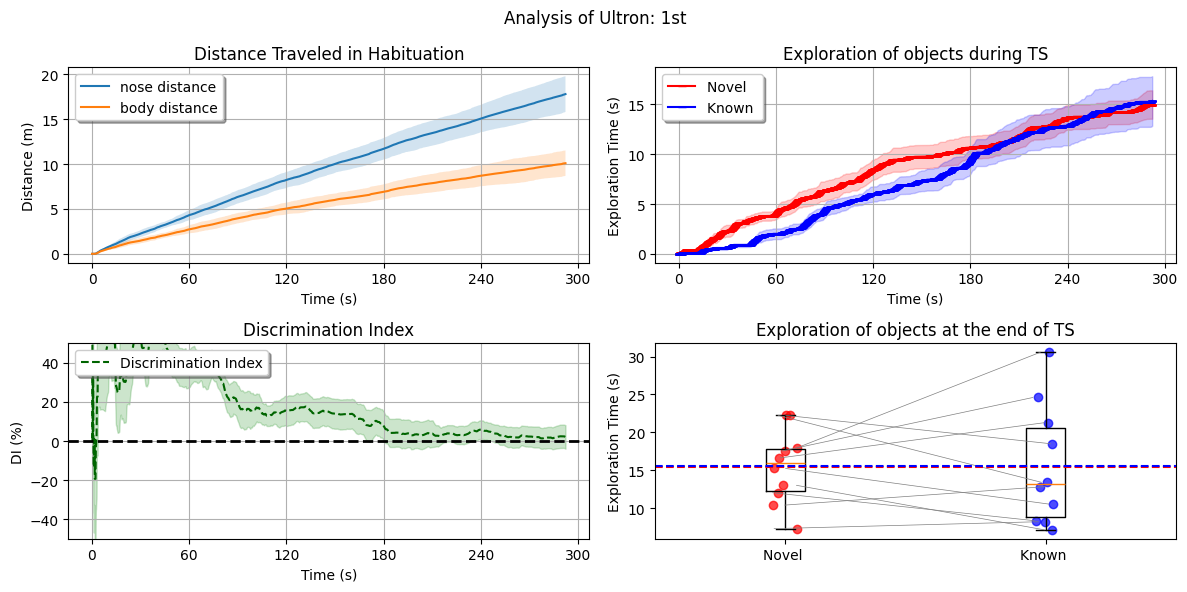

C:\Users\dhers\AppData\Local\Temp\ipykernel_6760\488893608.py:96: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1, 1].boxplot(bxplt[f'{A_files}'], positions=[1], labels=[f'{A_files}'])
C:\Users\dhers\AppData\Local\Temp\ipykernel_6760\488893608.py:97: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1, 1].boxplot(bxplt[f'{B_files}'], positions=[2], labels=[f'{B_files}'])


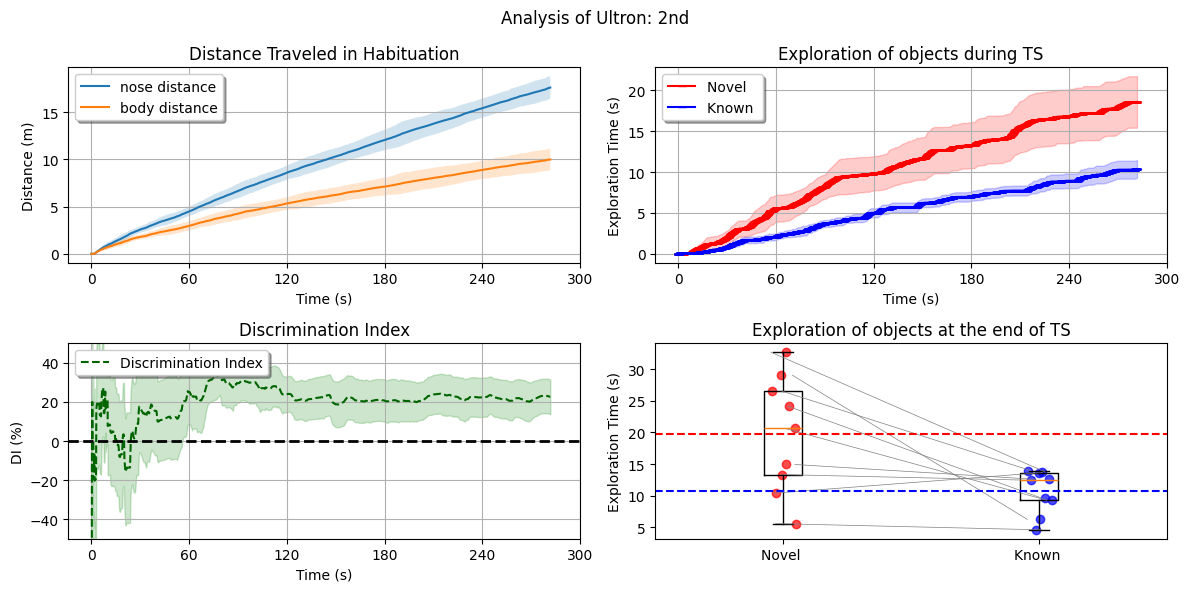

In [68]:
for group in groups:
    plot_groups(final_path, group, time_limit = None, fps = video_fps)

In [69]:
def plot_all(path, name_start, fps = 30):
    
    subfolders = path.split(os.path.sep) # list the name of the subfolders in the directory
    
    os.makedirs(os.path.join(path, "plots"), exist_ok = True)
    
    # Iterate through CSV files in the folder
    for filename in os.listdir(path):
        if filename.startswith(name_start):
        
            file_path = os.path.join(path, filename)
            file = pd.read_csv(file_path)
            file = calc_cum_sums(file, fps)
            
            distance_path = file_path.replace(f"{subfolders[-1]}", "movement").replace(f"{name_start}_", "")
            distance = pd.read_csv(distance_path)
            file["nose_dist_cumsum"] = distance["nose_dist"].cumsum()
            file["body_dist_cumsum"] = distance["body_dist"].cumsum()
                        
            position_file_path = file_path.replace(f"{subfolders[-1]}", "position").replace(f"{name_start}_", "")
            position = pd.read_csv(position_file_path)
            
            # Create a single figure
            fig, axes = plt.subplots(2, 2, figsize=(16, 8))
            
            file['time_seconds'] = file['Frame'] / fps
            
            # Distance covered
            axes[0, 0].plot(file['time_seconds'], file['nose_dist_cumsum'], label='Nose Distance')
            axes[0, 0].plot(file['time_seconds'], file['body_dist_cumsum'], label='Body Distance')
            axes[0, 0].set_xlabel('Time (s)')
            axes[0, 0].set_xticks([0, 60, 120, 180, 240, 300])
            axes[0, 0].set_ylabel('Distance Traveled (m)')
            # axes[0, 0].set_ylim(0, 4000)
            axes[0, 0].set_title('Hab')
            axes[0, 0].legend(loc='upper left', fancybox=True, shadow=True)
            axes[0, 0].grid(True)
            
            # Object exploration
            axes[0, 1].plot(file['time_seconds'], file[f'{file.columns[1]}'], label=f'{file.columns[1]}', color='red', marker='_')
            axes[0, 1].plot(file['time_seconds'], file[f'{file.columns[2]}'], label=f'{file.columns[2]}', color='blue', marker='_')
            axes[0, 1].set_xlabel('Time (s)')
            axes[0, 1].set_xticks([0, 60, 120, 180, 240, 300])
            axes[0, 1].set_ylabel('Exploration Time (s)')
            axes[0, 1].set_title('file')
            axes[0, 1].legend(loc='upper left', fancybox=True, shadow=True)
            axes[0, 1].grid(True)
    
            # Discrimination Index
            axes[1, 0].plot(file['time_seconds'], file['Discrimination_Index'], label='Discrimination Index', color='green', linestyle='--', linewidth=3)
            axes[1, 0].set_xlabel('Time (s)')
            axes[1, 0].set_xticks([0, 60, 120, 180, 240, 300])
            axes[1, 0].set_ylabel('DI (%)')
            # axes[1, 0].set_ylim(-50, 50)
            axes[1, 0].set_title('Discrimination Index')
            axes[1, 0].legend(loc='upper left', fancybox=True, shadow=True)
            axes[1, 0].grid(True)
            axes[1, 0].axhline(y=0, color='black', linestyle=':', linewidth=3)
            
            # Positions
            
            nose, towards1, towards2, obj1, obj2 = Extract_positions(position)

            """
            Finally, we can plot the points that match both conditions
            """
            
            # Plot the nose positions
            axes[1, 1].plot(*nose.positions.T, ".", color = "grey", alpha = 0.15)
            
            # Plot the filtered points
            axes[1, 1].plot(*towards1.T, ".", label = "Oriented towards 1", color = "brown", alpha = 0.3)
            axes[1, 1].plot(*towards2.T, ".", label = "Oriented towards 2", color = "teal", alpha = 0.3)
            
            # Plot the objects
            axes[1, 1].plot(*obj1.positions[0], "s", lw = 20, label = "Object 1", color = "blue", markersize = 9, markeredgecolor = "blue")
            axes[1, 1].plot(*obj2.positions[0], "o", lw = 20, label = "Object 2", color = "red", markersize = 10, markeredgecolor = "darkred")
            
            # Plot the circles of distance criteria
            axes[1, 1].add_artist(Circle(obj1.positions[0], 2.5, color = "orange", alpha = 0.3))
            axes[1, 1].add_artist(Circle(obj2.positions[0], 2.5, color = "orange", alpha = 0.3))
            
            axes[1, 1].axis('equal')
            axes[1, 1].set_xlabel("Horizontal position (cm)")
            axes[1, 1].set_ylabel("Vertical position (cm)")
            axes[1, 1].legend(loc='upper left', ncol=2, fancybox=True, shadow=True)
            axes[1, 1].grid(True)
            
            file_name = os.path.basename(file_path)
            
            plt.suptitle(f"Analysis of {subfolders[-3]}: {file_name}", y=0.98)  # Add DataFrame name as the overall title
            plt.tight_layout()
            plt.savefig(os.path.join(path, "plots", f"{file_name}_plot.png"))
            plt.show()

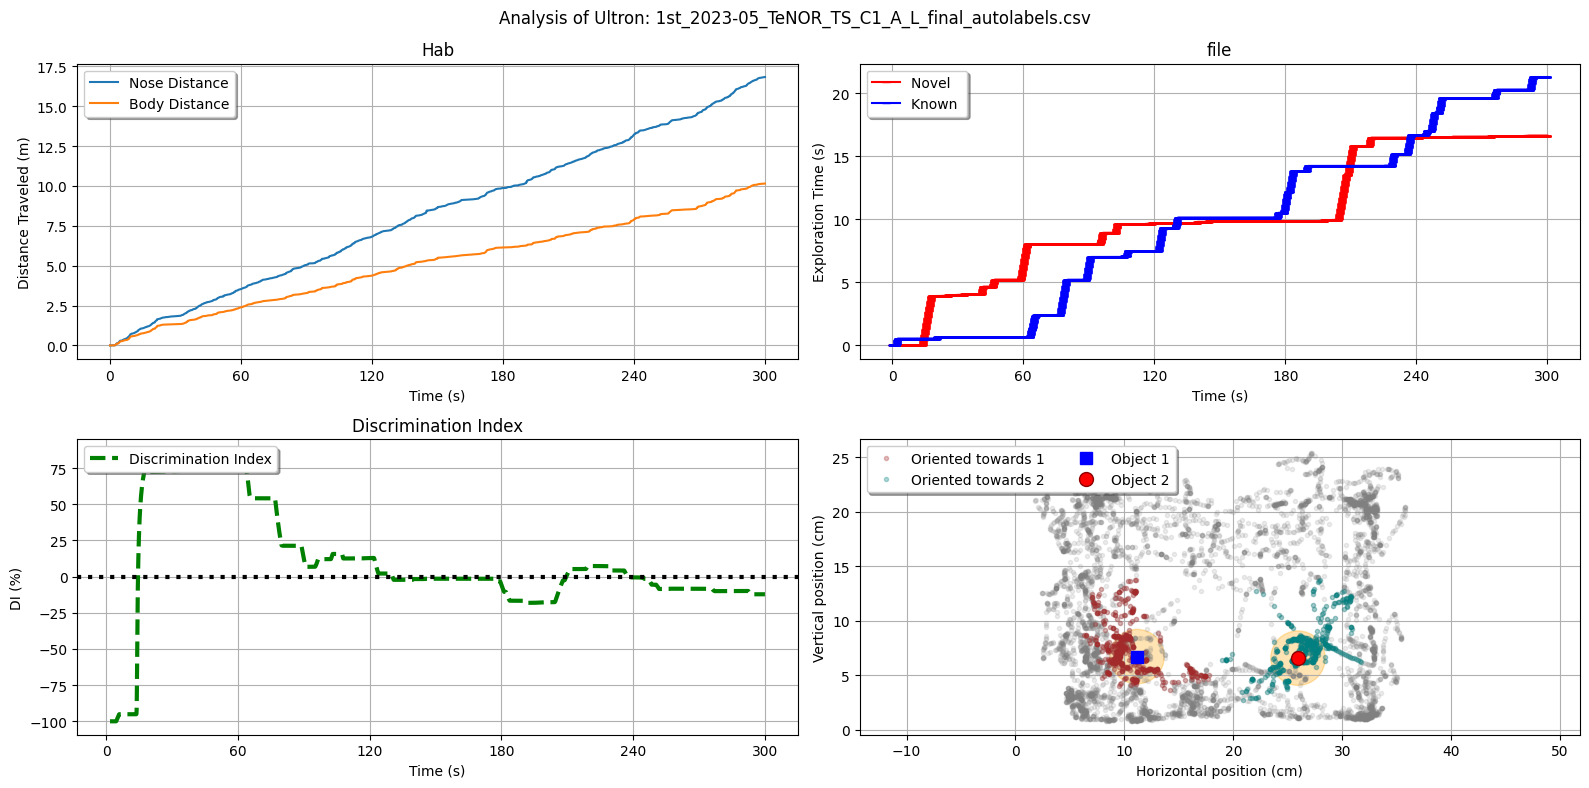

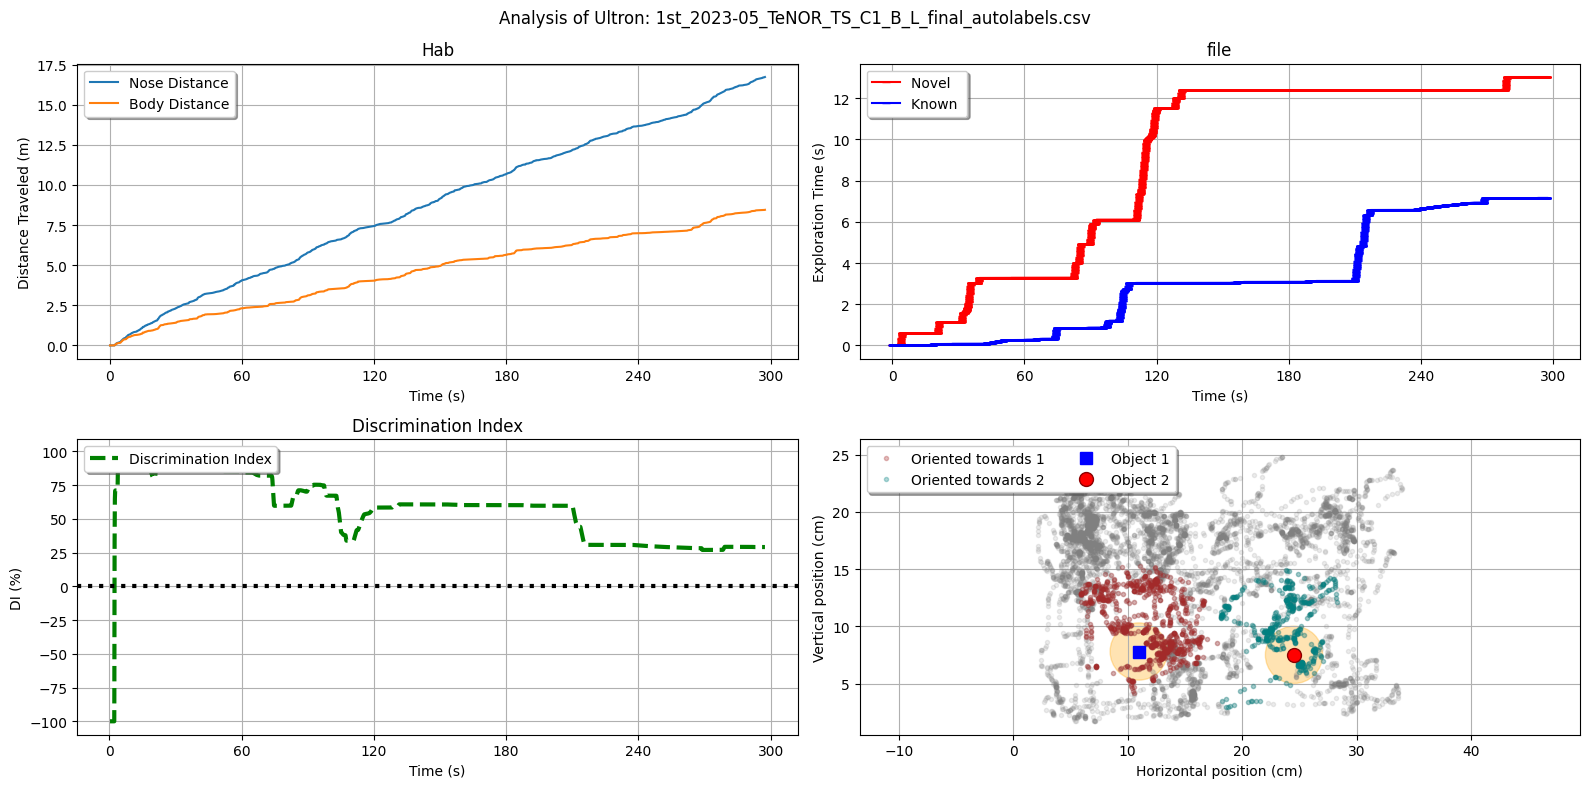

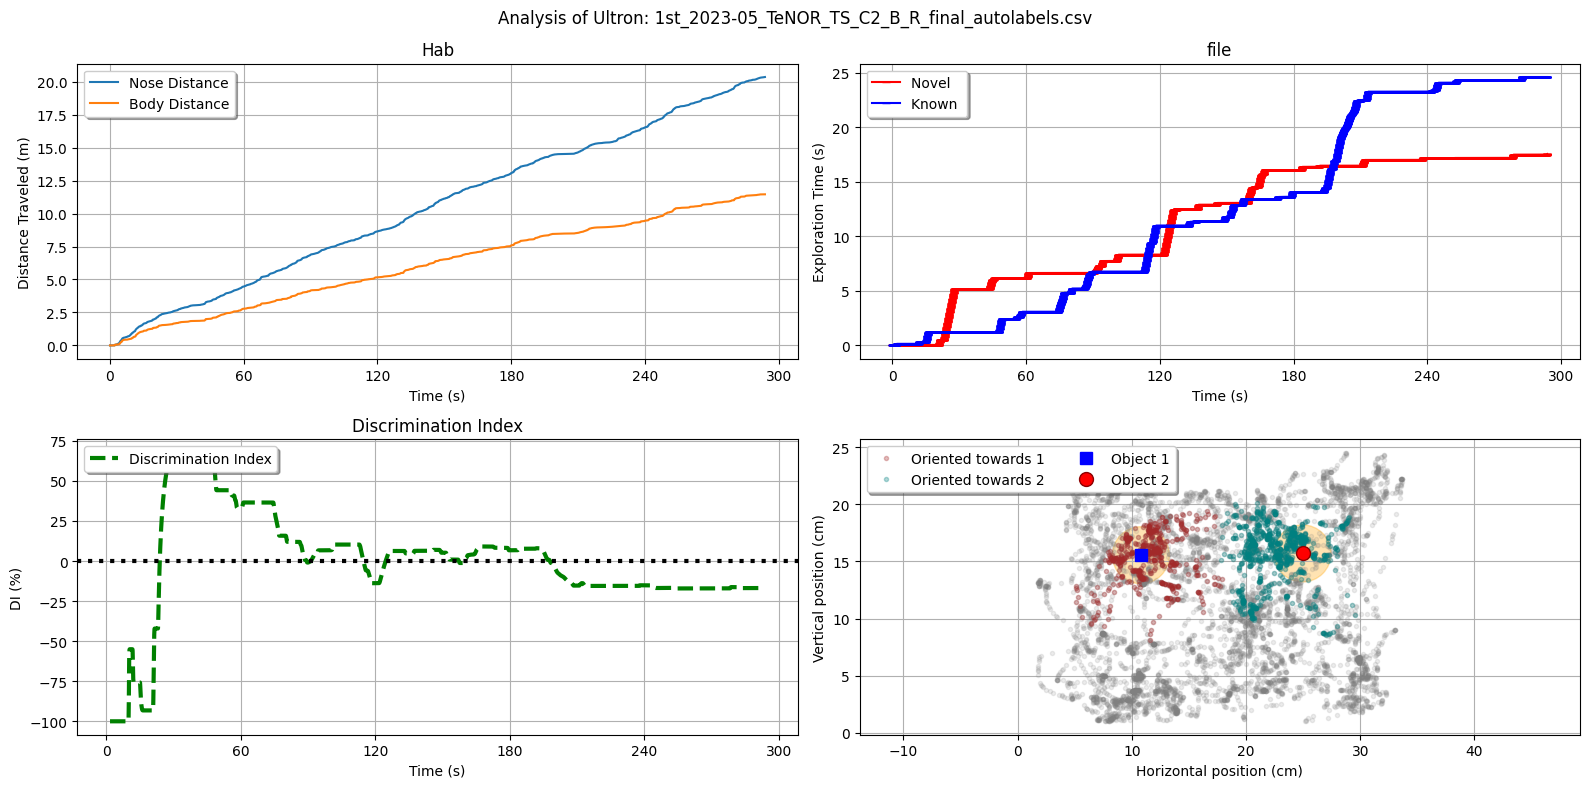

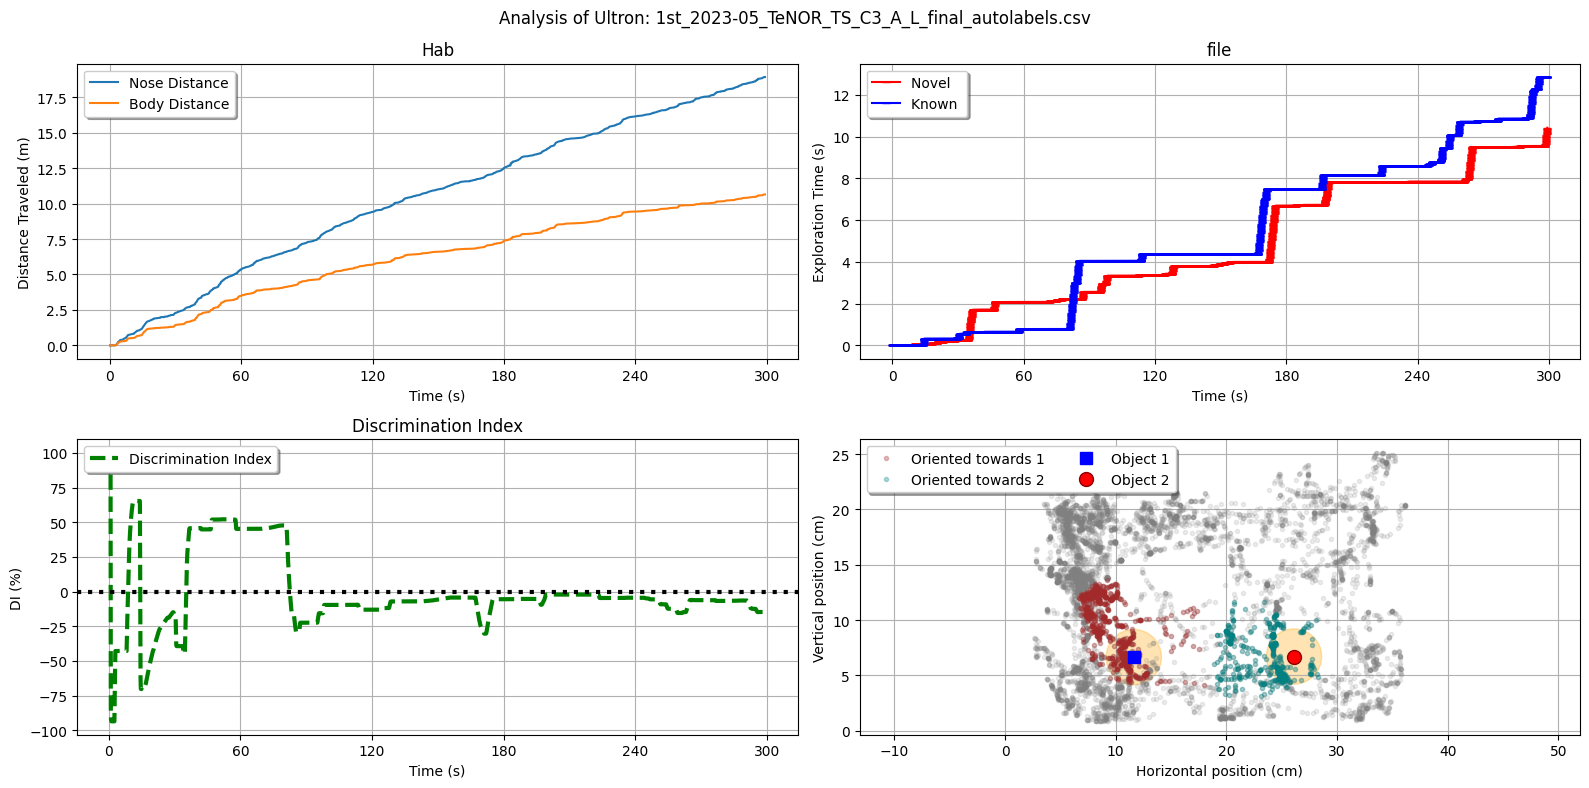

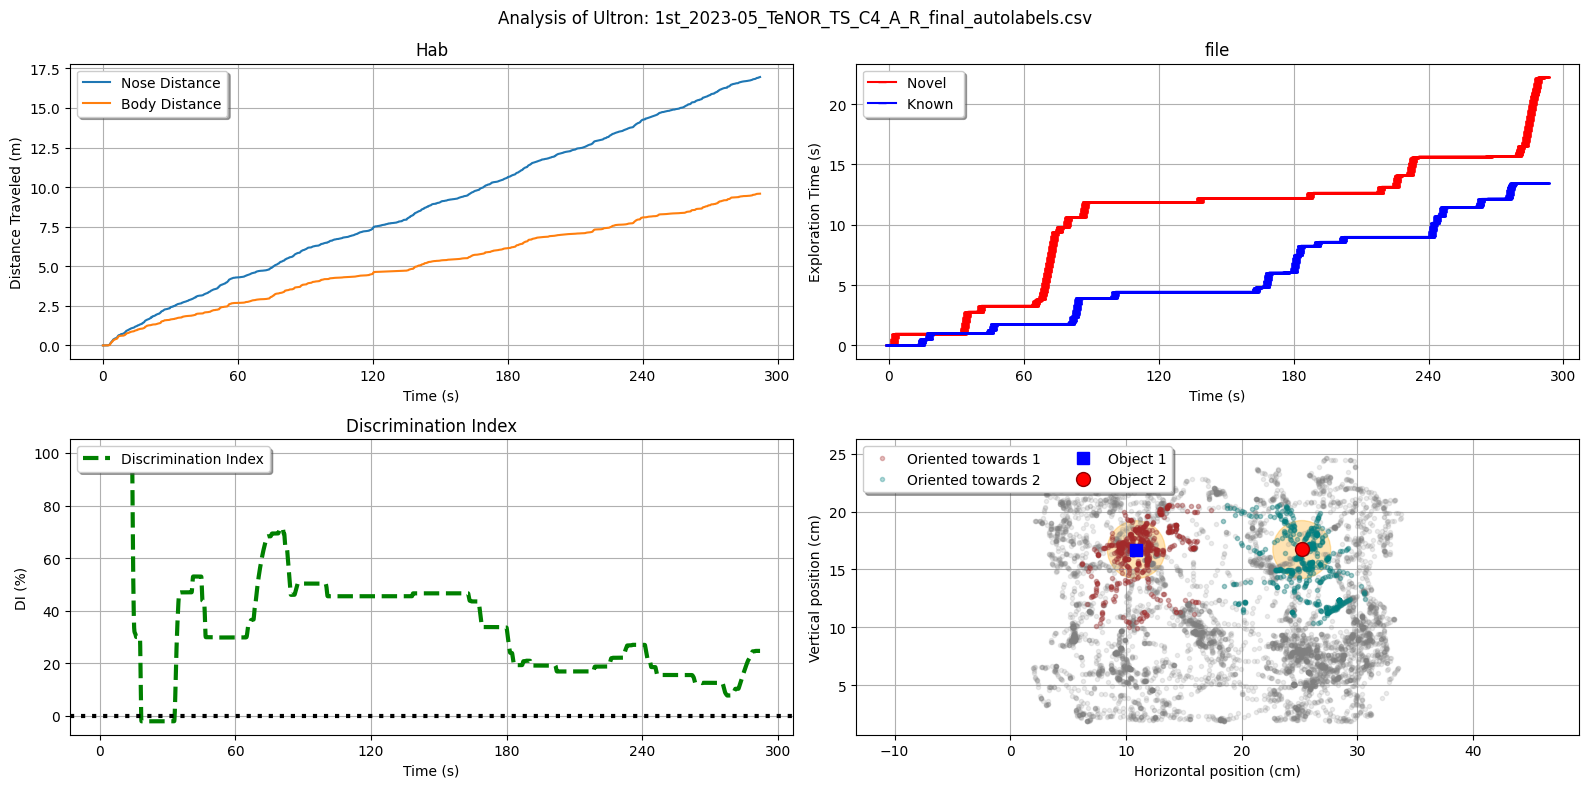

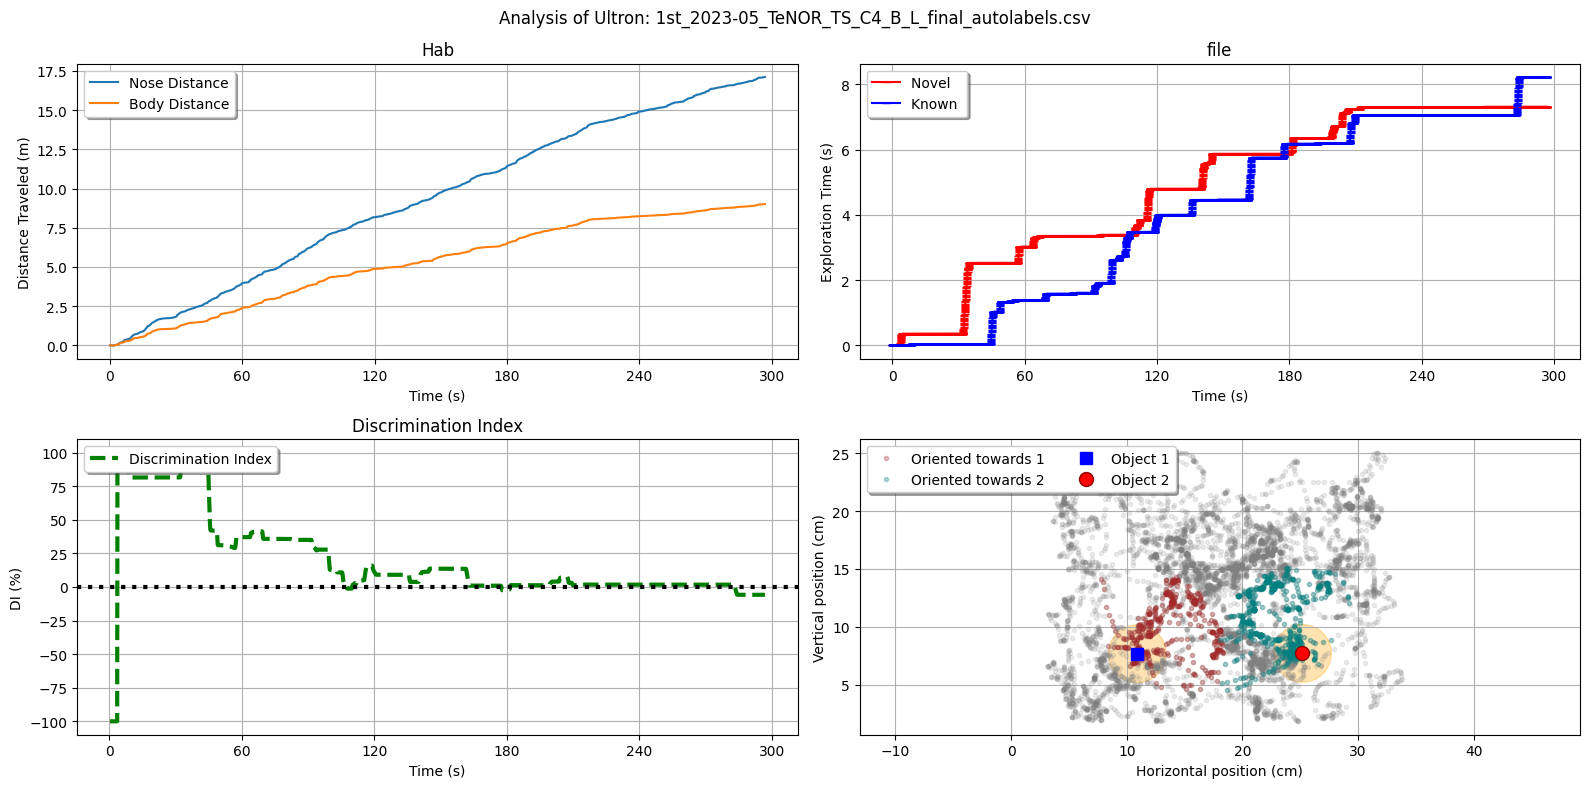

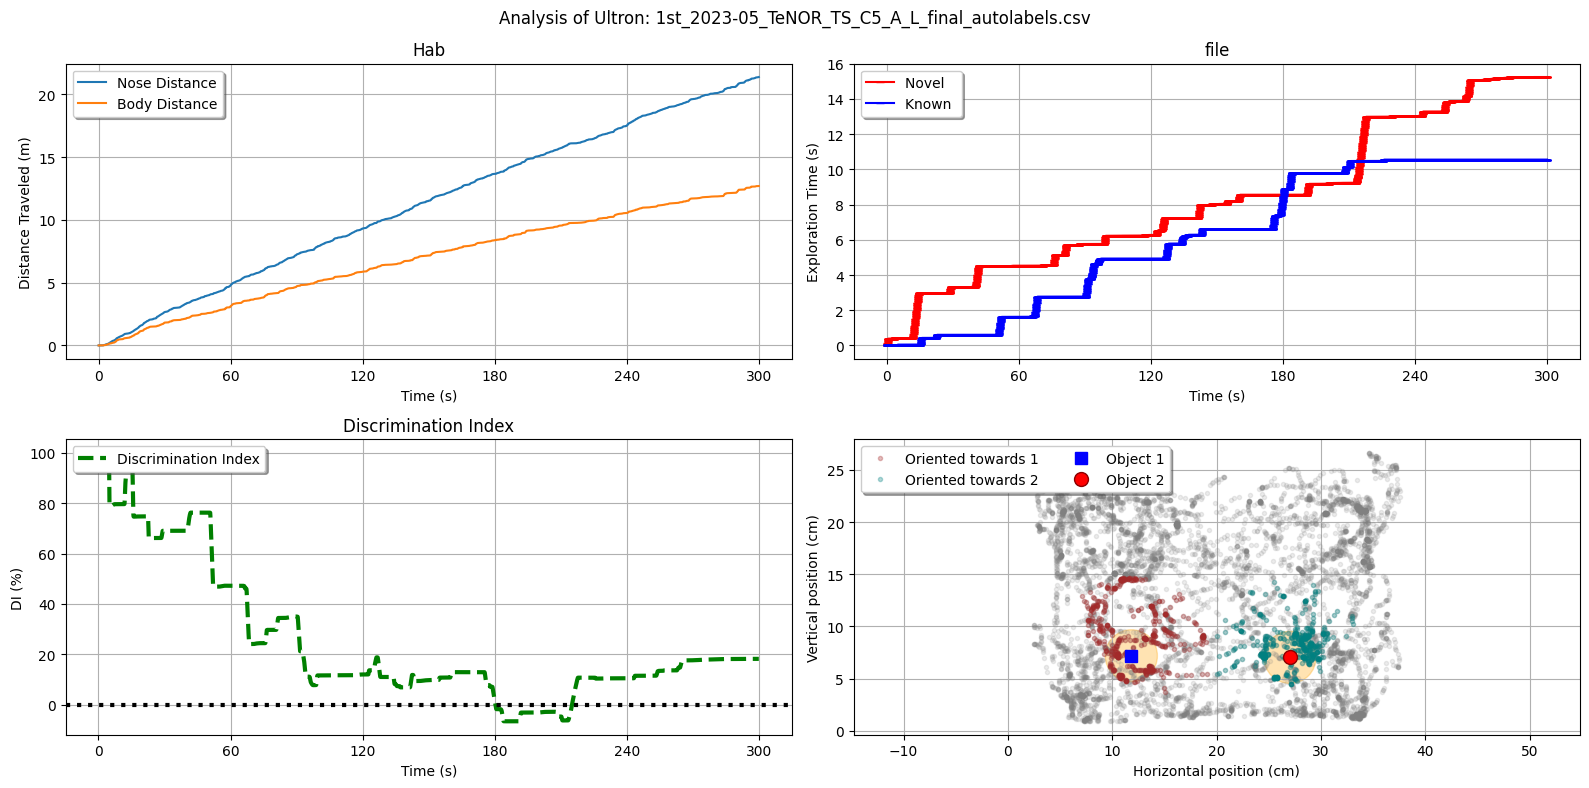

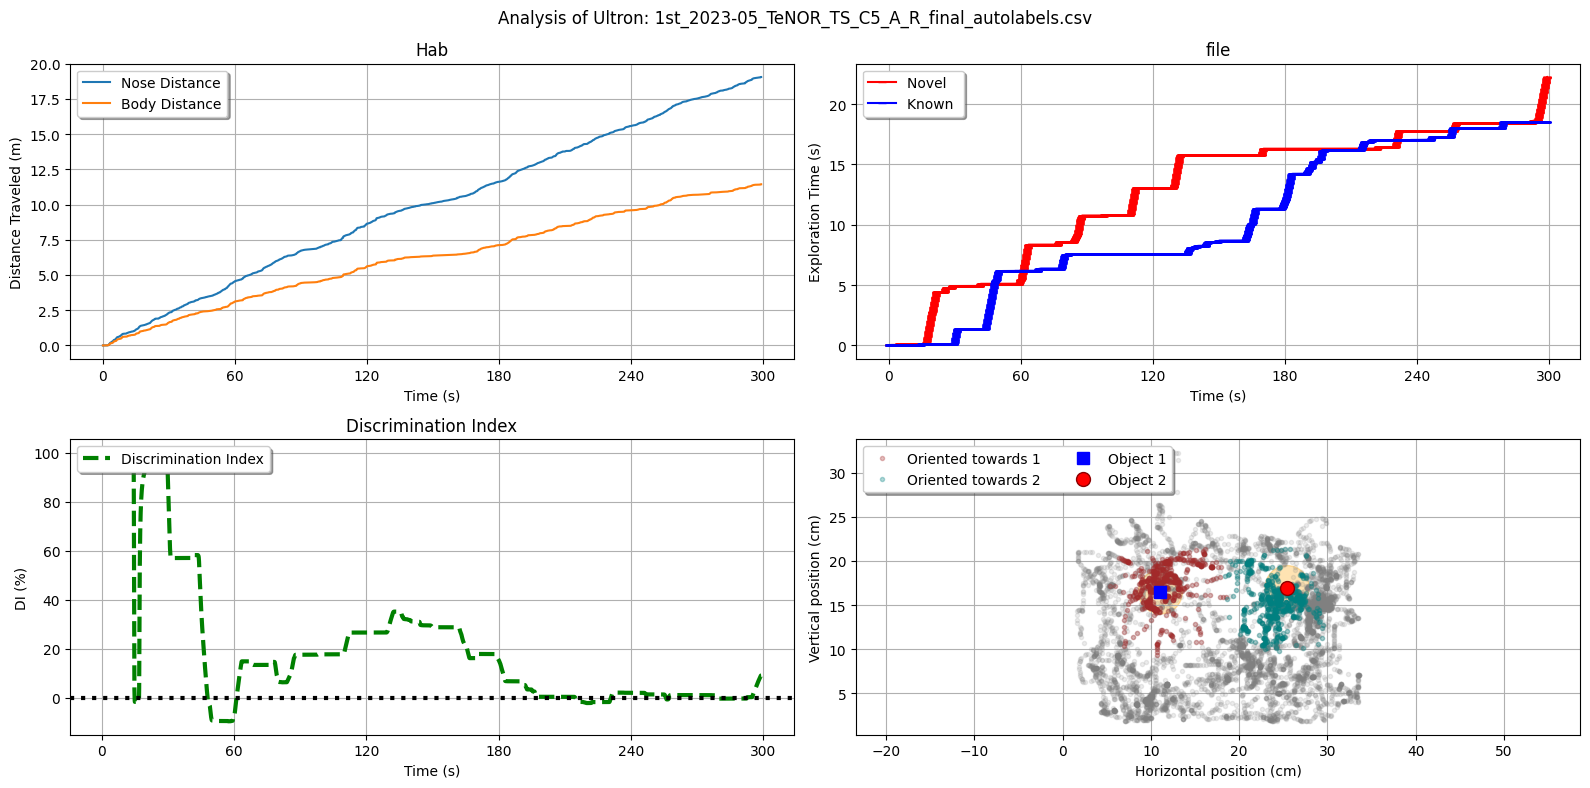

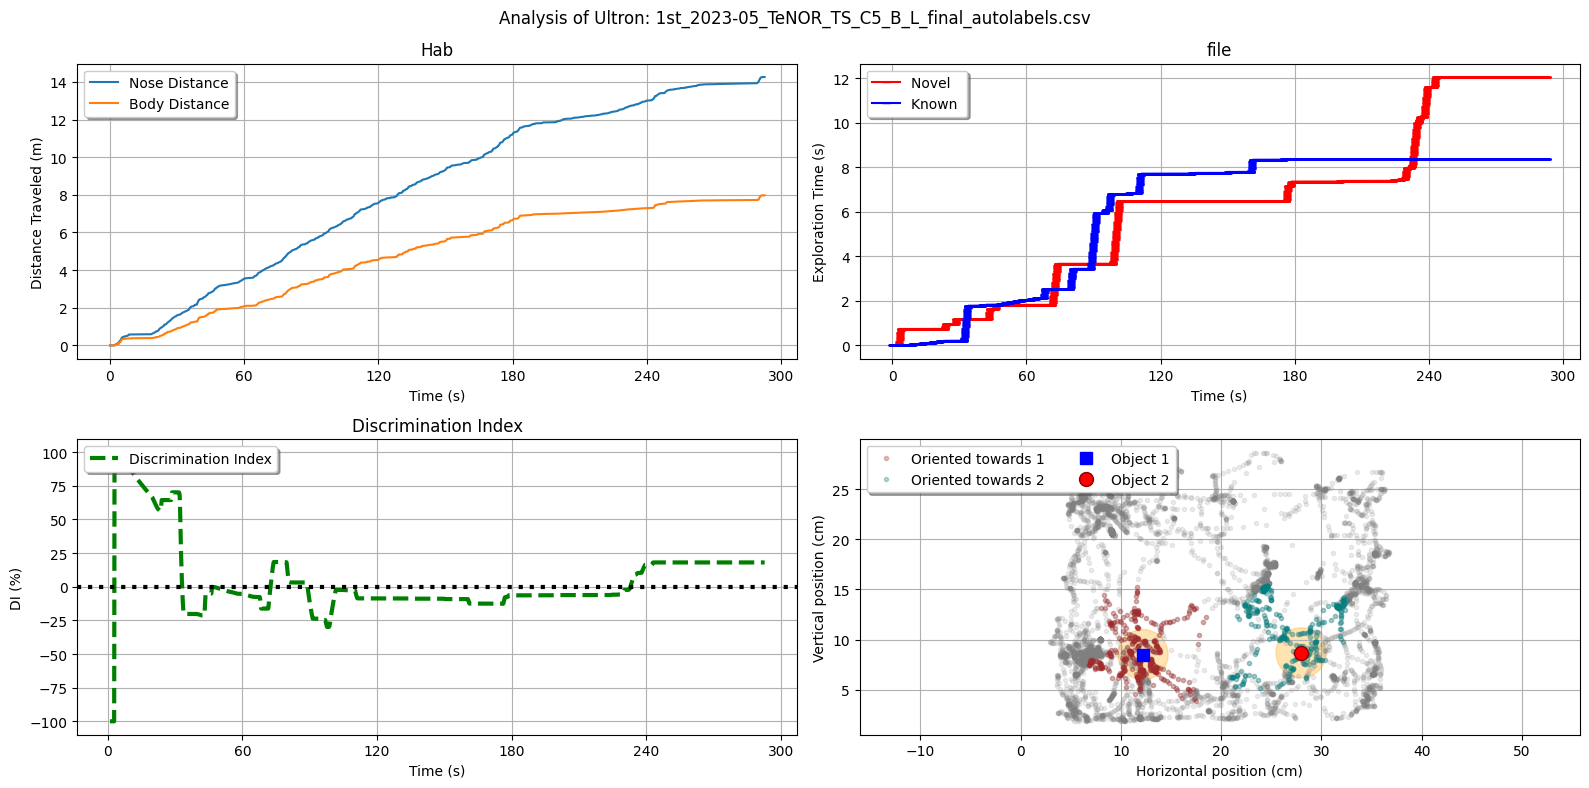

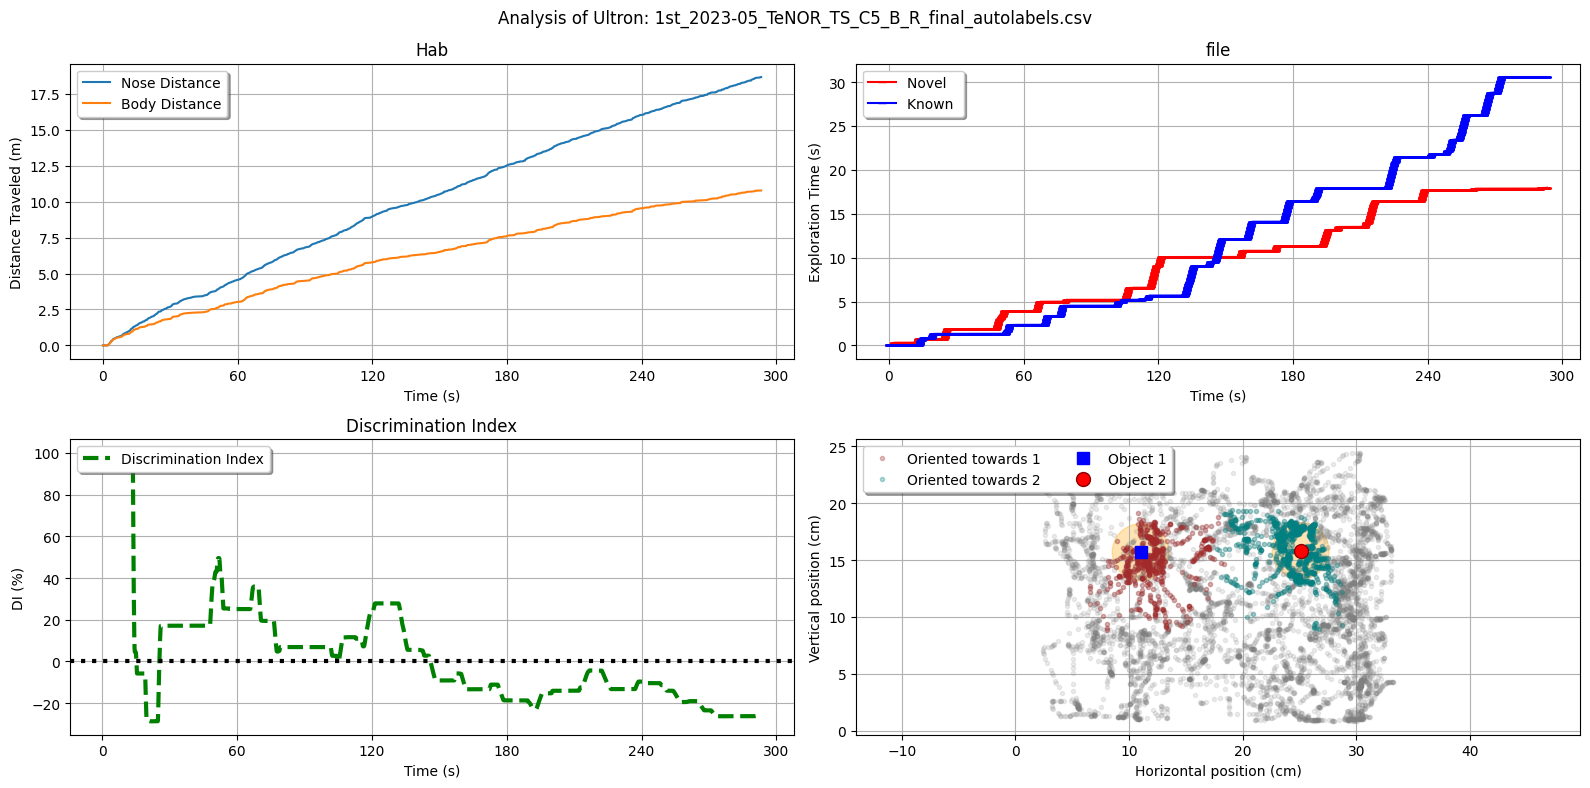

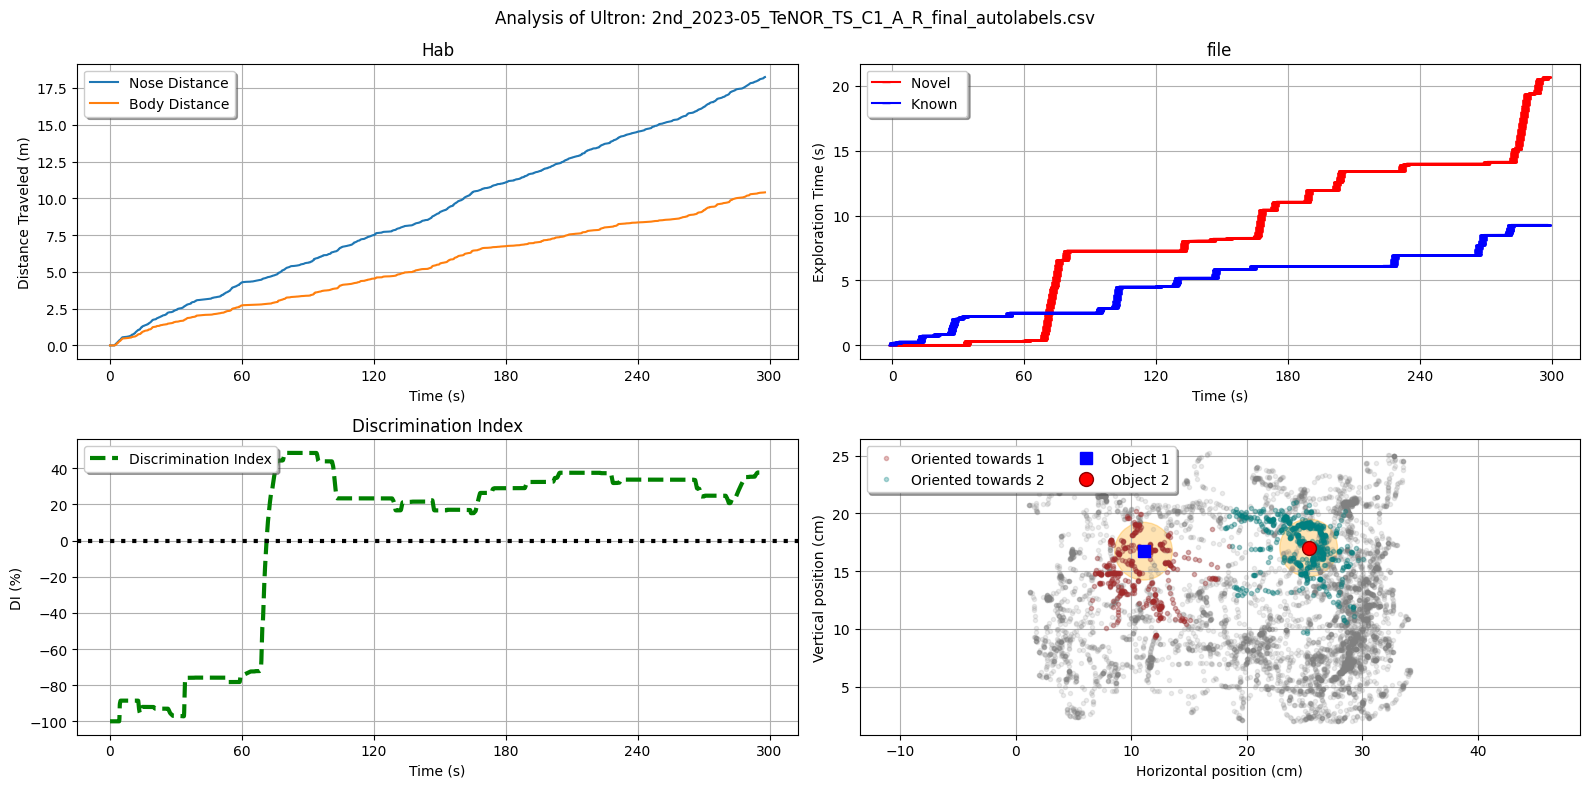

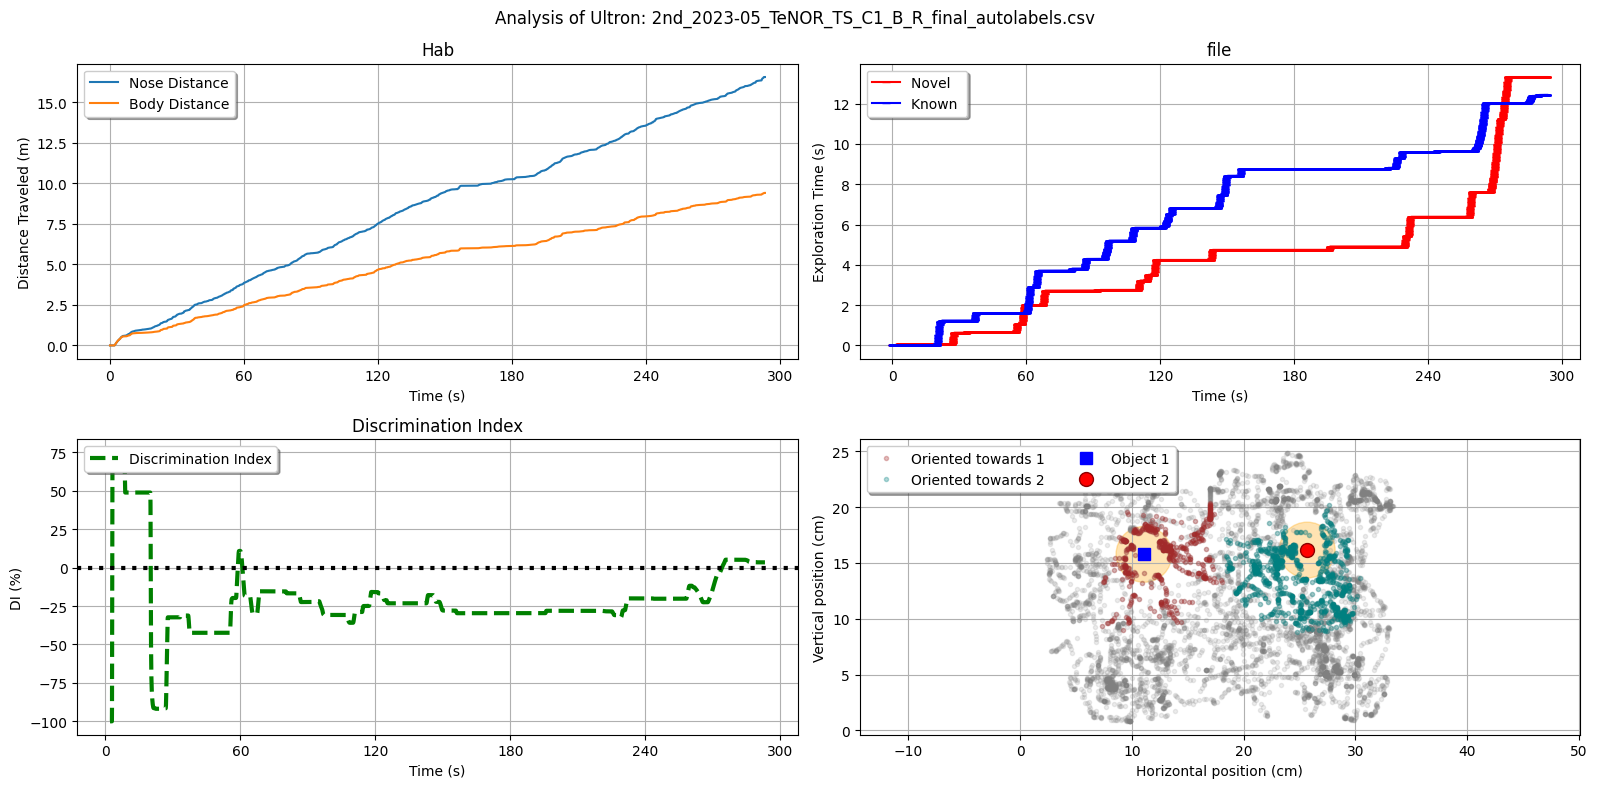

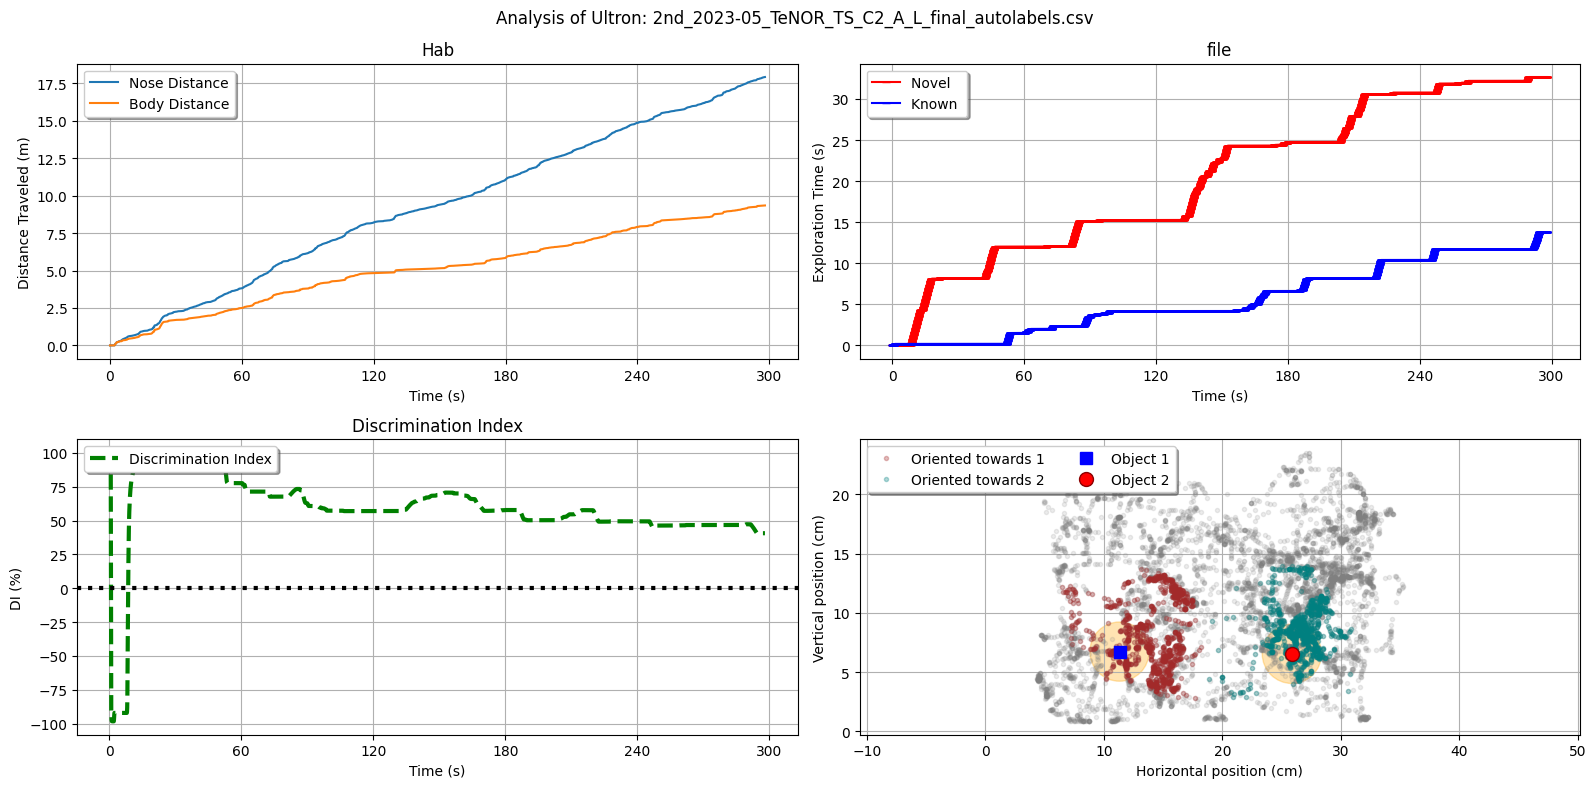

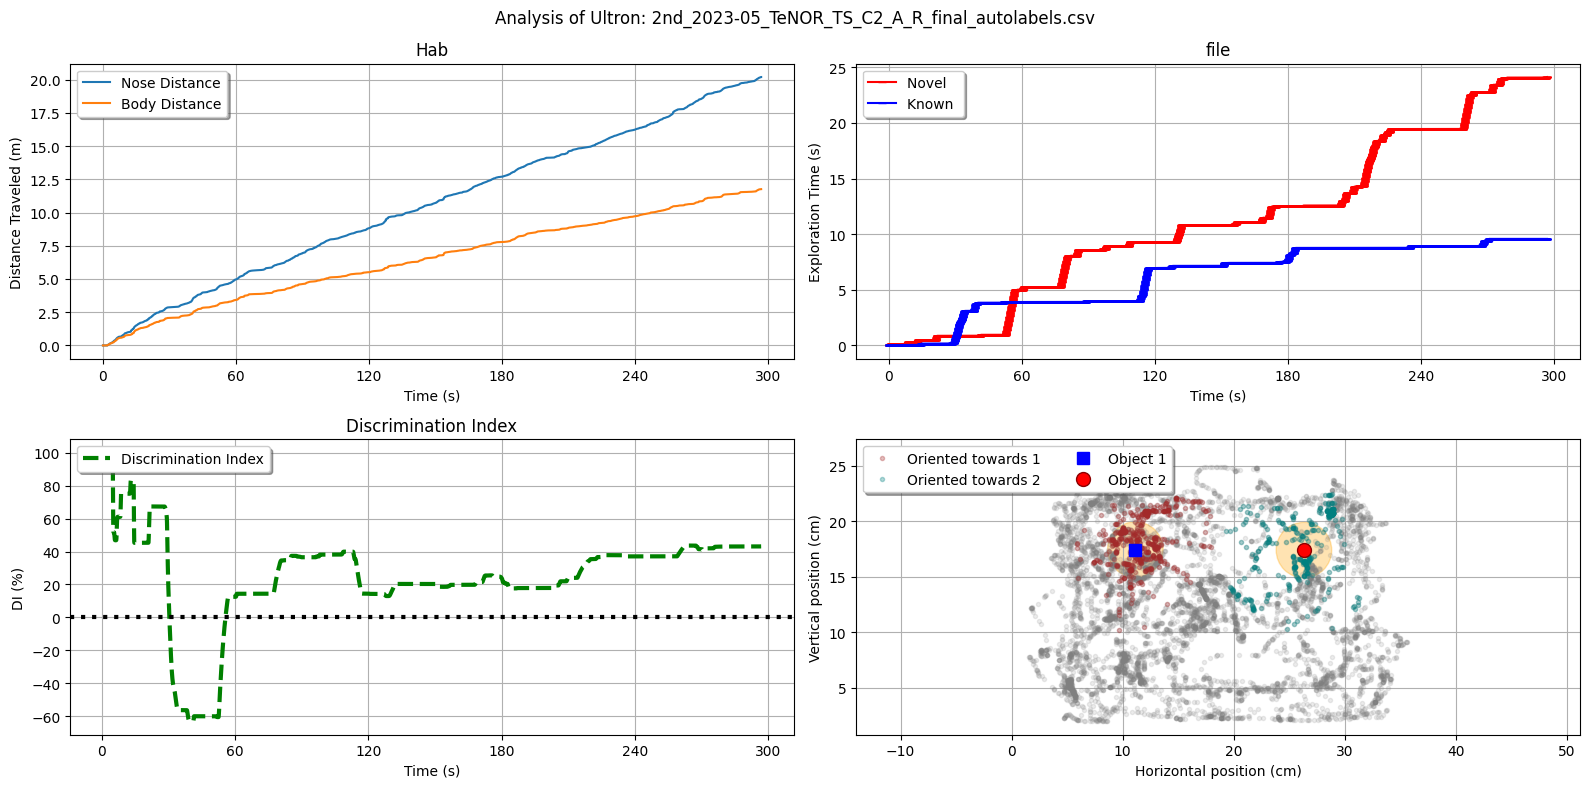

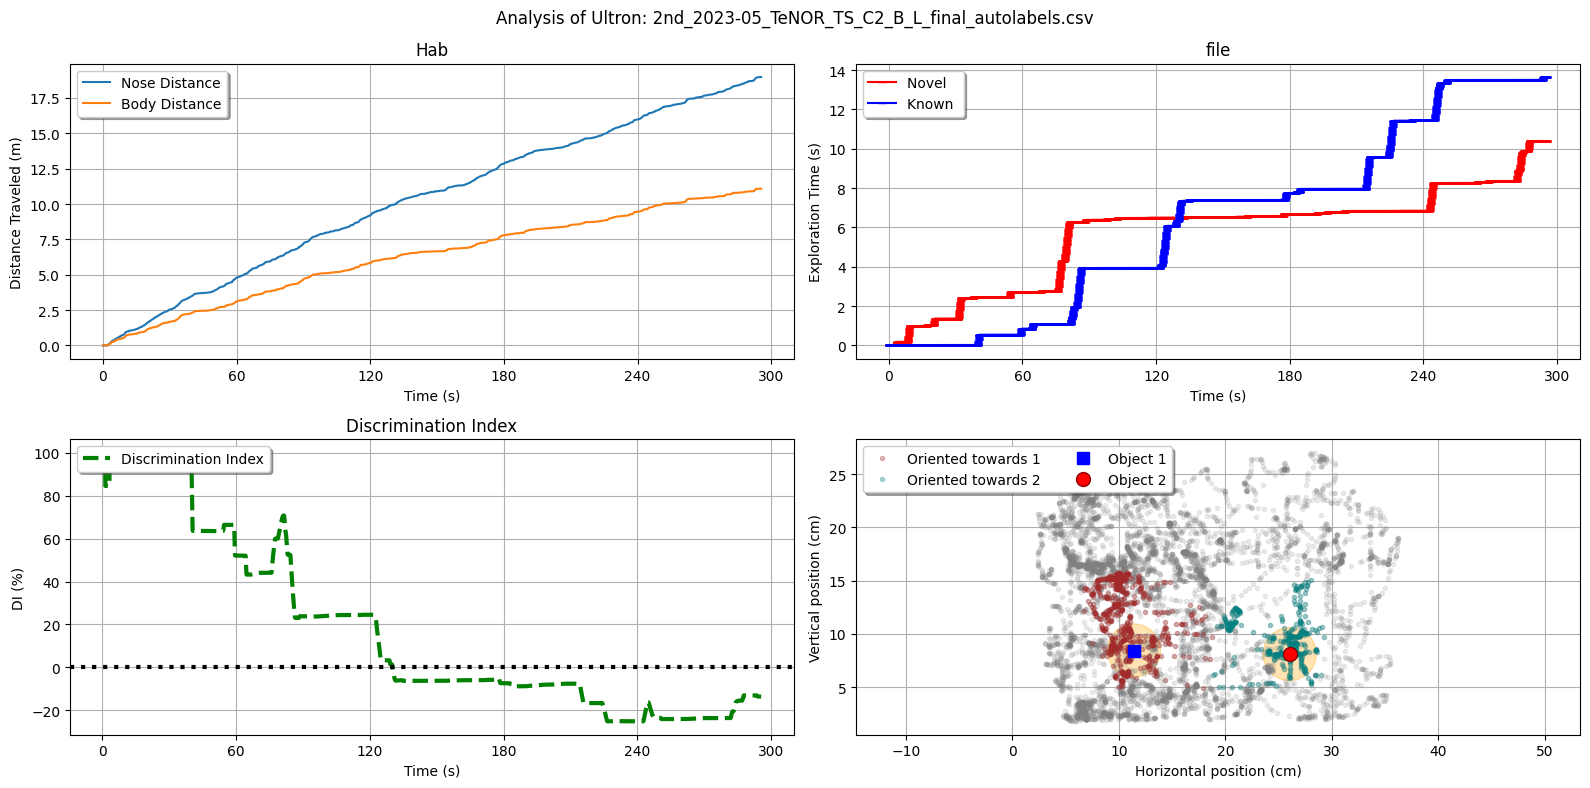

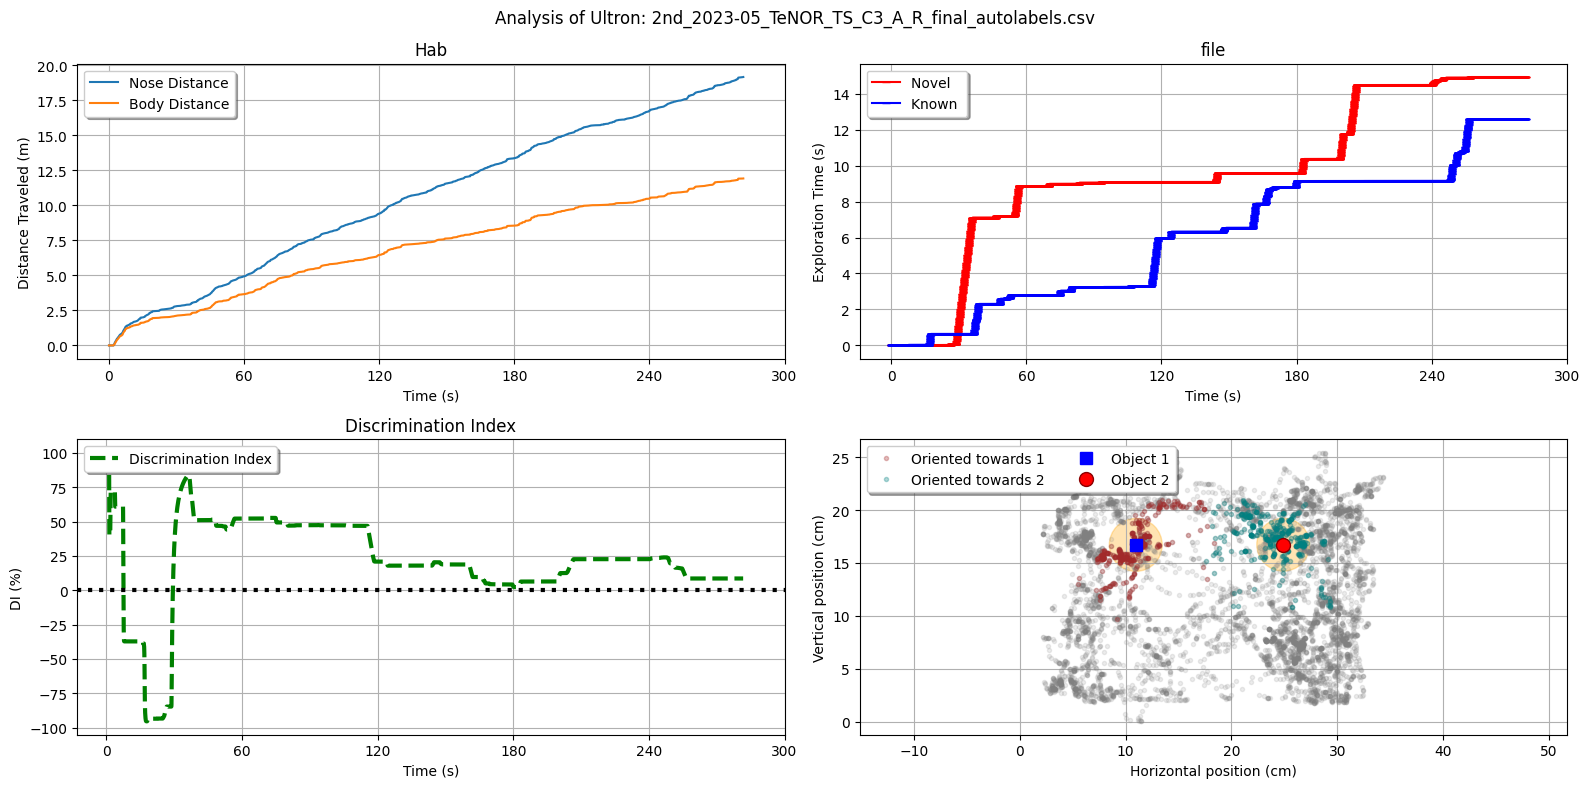

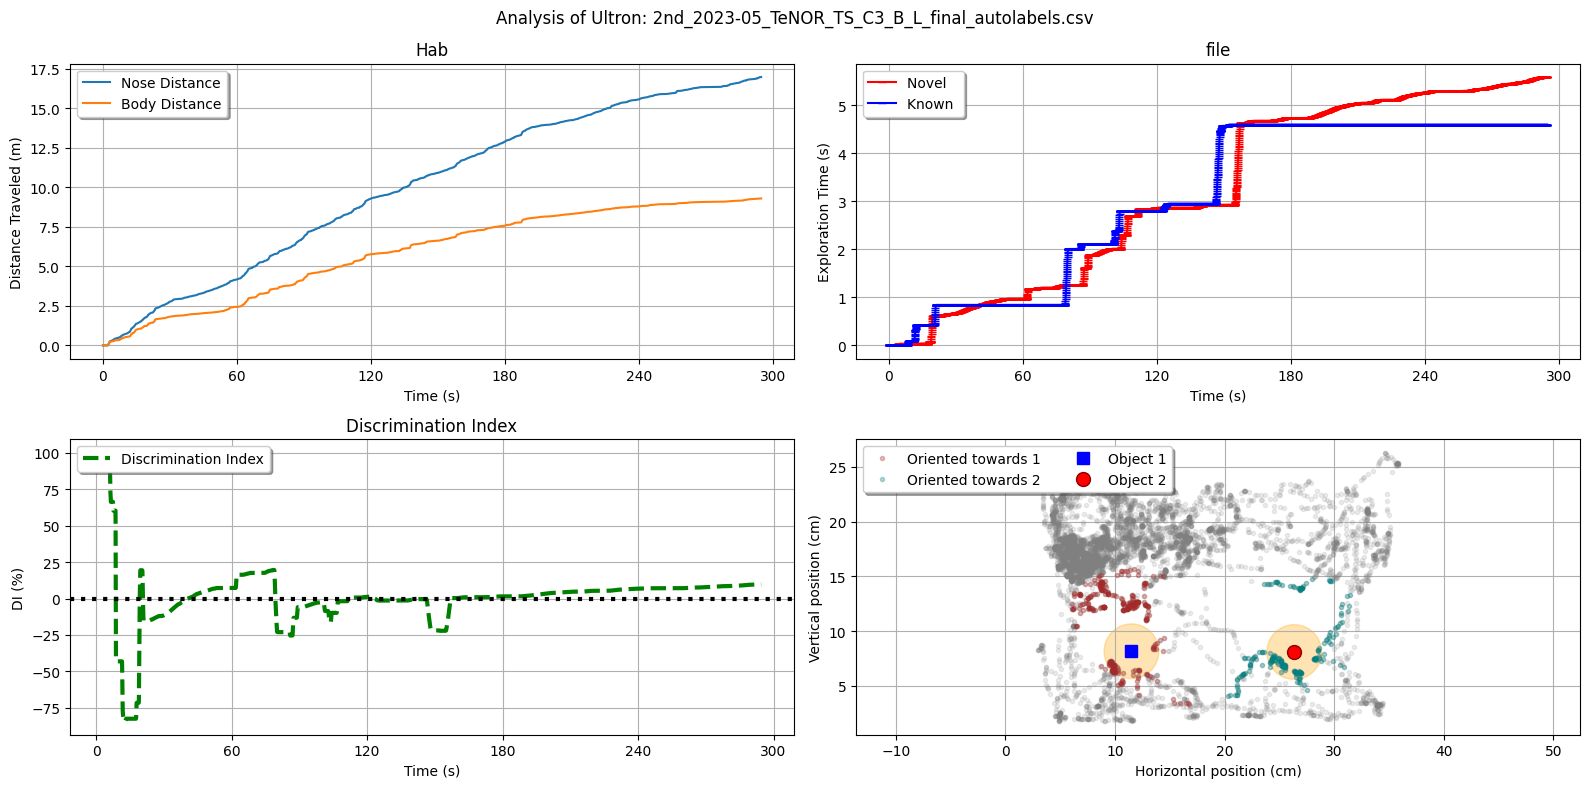

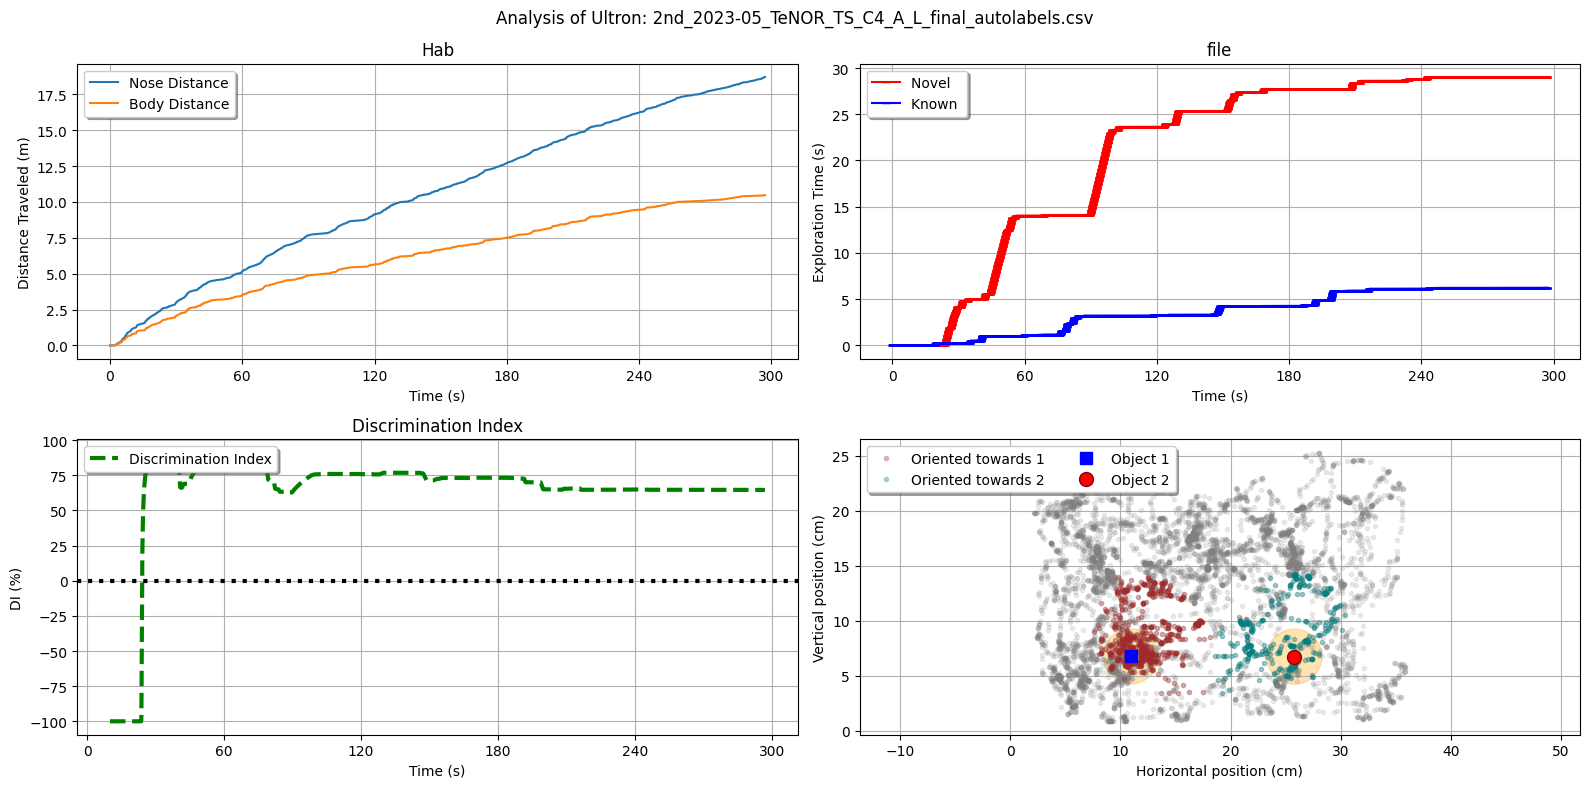

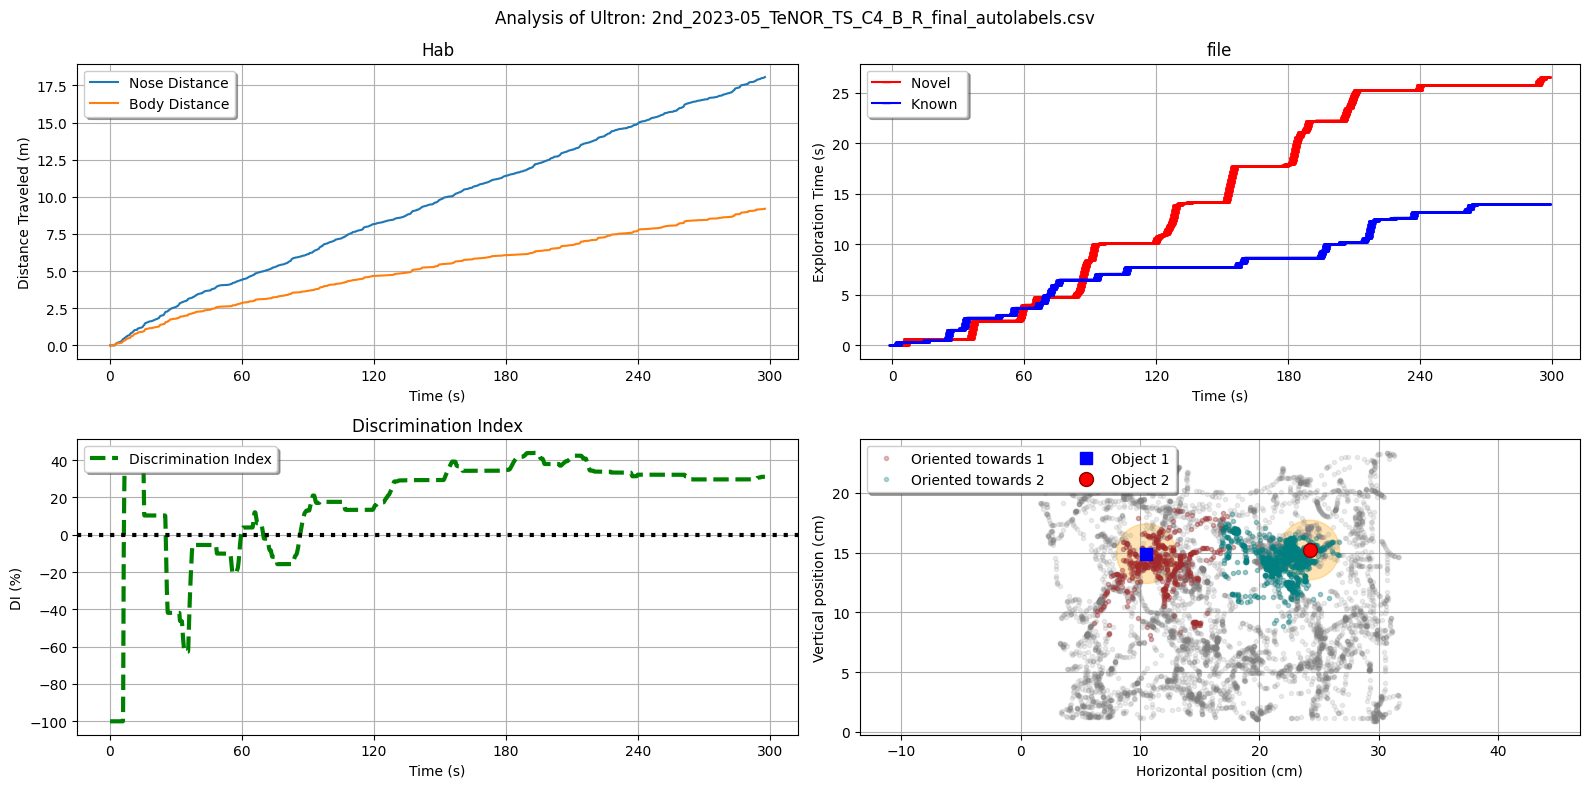

In [70]:
for group in groups:
    plot_all(final_path, group, fps = video_fps)

In [104]:
def plot_experiment(path, group_list, time_limit = None, fps = 30):
    
    subfolders = path.split(os.path.sep) # list the name of the subfolders in the directory
    
    # Create a single figure
    fig, axes = plt.subplots(2, 3, figsize=(16, 8))
    
    bxplt_positions = list(range(1, len(group_list) + 1))
        
    for i, name_start in enumerate(group_list):
        # Initialize an empty list to store DataFrames
        files = []
        bxplt = []
        exp_A = []
        exp_B = []
        
        # Iterate through CSV files in the folder
        for filename in os.listdir(path):
            if filename.startswith(name_start):
            
                file_path = os.path.join(path, filename)
                file = pd.read_csv(file_path)
                file = calc_cum_sums(file, fps)
                
                distance_path = file_path.replace(f"{subfolders[-1]}", "movement").replace(f"{name_start}_", "")
                distance = pd.read_csv(distance_path)
                file["nose_dist_cumsum"] = distance["nose_dist"].cumsum()
                file["body_dist_cumsum"] = distance["body_dist"].cumsum()

                file["freezing"] = distance["freezing"].cumsum() / fps
                file["darting"] = distance["darting"].cumsum() / fps
                
                files.append(file)

                bx_index = -1
                if time_limit is not None:
                    bx_index = time_limit*fps
                
                bxplt.append(file.loc[file.index[bx_index], "Discrimination_Index"])
                exp_A.append(file.loc[file.index[bx_index], f"{file.columns[1]}"])
                exp_B.append(file.loc[file.index[bx_index], f"{file.columns[2]}"])
        
        bxplt = pd.DataFrame(bxplt)
        exp_A = np.array(exp_A)
        exp_B = np.array(exp_B)


        n = len(files) # We find the number of mice to calculate the standard error as std/sqrt(n)
        se = np.sqrt(n)
        
        # Find the minimum length of all files
        min_length = min([len(file) for file in files])
        if time_limit is not None:
            min_length = min(min_length, time_limit*fps)
        trunc_files = [file.iloc[:min_length] for file in files]

        # Concatenate the list of DataFrames into one DataFrame
        all_files = pd.concat(trunc_files, ignore_index=True)
        A_files = all_files.columns[1]
        B_files = all_files.columns[2]

        # Calculate the mean and standard deviation of cumulative sums for each frame
        df = all_files.groupby('Frame').agg(['mean', 'std', 'sum']).reset_index()
                
        df['time_seconds'] = df['Frame'] / fps
        
        # Distance covered
        axes[0, 0].plot(df['time_seconds'], df[("nose_dist_cumsum" ,'mean')], label = f'Nose - {name_start}')
        axes[0, 0].fill_between(df['time_seconds'], df[("nose_dist_cumsum" ,'mean')] - df[("nose_dist_cumsum", 'std')], df[("nose_dist_cumsum" ,'mean')] + df[("nose_dist_cumsum" ,'std')], alpha=0.2)
        axes[0, 0].plot(df['time_seconds'], df[("body_dist_cumsum" ,'mean')], label = f'Body - {name_start}')
        axes[0, 0].fill_between(df['time_seconds'], df[("body_dist_cumsum" ,'mean')] - df[("body_dist_cumsum", 'std')], df[("body_dist_cumsum" ,'mean')] + df[("body_dist_cumsum" ,'std')], alpha=0.2)
        axes[0, 0].set_xlabel('Time (s)')
        axes[0, 0].set_xticks([0, 60, 120, 180, 240, 300])
        axes[0, 0].set_ylabel('Distance (m)')
        # axes[0, 0].set_ylim(0, 4000)
        axes[0, 0].set_title('Distance Traveled')
        axes[0, 0].legend(loc='upper left', fancybox=True, shadow=True)
        axes[0, 0].grid(True)

        # Freezing
        axes[0, 1].plot(df['time_seconds'], df[("freezing" ,'mean')], label = f'freezing - {name_start}')
        axes[0, 1].fill_between(df['time_seconds'], df[("freezing" ,'mean')] - df[("freezing", 'std')], df[("freezing" ,'mean')] + df[("freezing" ,'std')], alpha=0.2)
        axes[0, 1].set_xlabel('Time (s)')
        axes[0, 1].set_xticks([0, 60, 120, 180, 240, 300])
        axes[0, 1].set_ylabel('duration (s)')
        # axes[0, 1].set_ylim(0, 4000)
        axes[0, 1].set_title('Freezing')
        axes[0, 1].legend(loc='upper left', fancybox=True, shadow=True)
        axes[0, 1].grid(True)

        # Scatter plot of exploration
        axes[1, 1].scatter(exp_B, exp_A)
        axes[1, 1].set_title('Scatter Plot')
        axes[1, 1].set_xlabel(f'time exploring the {B_files}object (s)')
        axes[1, 1].set_ylabel(f'time exploring the {A_files}object (s)')
        # axes[1, 1].set_aspect('equal', adjustable='box')
        
        # Calculate the slope with the intercept fixed at 0
        slope = np.sum(exp_B * exp_A) / np.sum(exp_B**2)

        # Create the trendline that passes through (0, 0)
        trendline_y = slope * exp_B
        axes[1, 1].plot(exp_B, trendline_y, label=f'{A_files}/ {B_files} - {name_start}')

        #axes[1, 1].set_xlim(0, 45)
        #axes[1, 1].set_ylim(0, 32)
        axes[1, 1].legend(loc='upper right', fancybox=True, shadow=True)
        axes[1, 1].grid(True)
        
        # Object exploration
        axes[0, 2].plot(df['time_seconds'], df[(f'{A_files}' ,'mean')], label = f'{A_files} - {name_start}', marker='_')
        axes[0, 2].fill_between(df['time_seconds'], df[(f'{A_files}' ,'mean')] - df[(f'{A_files}', 'std')] /se, df[(f'{A_files}' ,'mean')] + df[(f'{A_files}' ,'std')] /se, alpha=0.2)
        axes[0, 2].plot(df['time_seconds'], df[(f'{B_files}' ,'mean')], label = f'{B_files} - {name_start}', marker='_')
        axes[0, 2].fill_between(df['time_seconds'], df[(f'{B_files}' ,'mean')] - df[(f'{B_files}', 'std')] /se, df[(f'{B_files}' ,'mean')] + df[(f'{B_files}' ,'std')] /se, alpha=0.2)
        axes[0, 2].set_xlabel('Time (s)')
        axes[0, 2].set_xticks([0, 60, 120, 180, 240, 300])
        axes[0, 2].set_ylabel('Exploration Time (s)')
        axes[0, 2].set_title('Exploration of objects')
        axes[0, 2].legend(loc='upper left', fancybox=True, shadow=True)
        axes[0, 2].grid(True)
        
        # Discrimination Index
        axes[1, 0].plot(df['time_seconds'], df[('Discrimination_Index', 'mean')], label=f'DI - {name_start}', linestyle='--')
        axes[1, 0].fill_between(df['time_seconds'], df[('Discrimination_Index', 'mean')] - df[('Discrimination_Index', 'std')] /se, df[('Discrimination_Index', 'mean')] + df[('Discrimination_Index', 'std')] /se, alpha=0.2)
        axes[1, 0].set_xlabel('Time (s)')
        axes[1, 0].set_xticks([0, 60, 120, 180, 240, 300])
        axes[1, 0].set_ylabel('DI (%)')
        axes[1, 0].set_ylim(-15, 75)
        axes[1, 0].axhline(y=0, color='black', linestyle='--', linewidth = 2)
        axes[1, 0].set_title('Discrimination Index')
        axes[1, 0].legend(loc='upper right', fancybox=True, shadow=True)
        axes[1, 0].grid(True)

        if time_limit is not None:
            axes[0, 0].set_xlim(-10, time_limit + 10)
            axes[0, 1].set_xlim(-10, time_limit + 10)
            axes[0, 2].set_xlim(-10, time_limit + 10)
            axes[1, 0].set_xlim(-10, time_limit + 10)
        
        # Boxplot
        axes[1, 2].boxplot(bxplt[0], positions=[bxplt_positions[i]], tick_labels = [f'{name_start}'])
        
        # Replace boxplots with scatter plots with jitter
        jitter_amount = 0.05  # Adjust the jitter amount as needed
        axes[1, 2].scatter([i + 1 + np.random.uniform(-jitter_amount, jitter_amount) for _ in range(len(bxplt[0]))], bxplt[0], alpha=0.7, label=f'{name_start}')
        
        axes[1, 2].axhline(y=0, color='black', linestyle='--', linewidth = 2)
        axes[1, 2].set_ylabel('DI (%)')
        axes[1, 2].set_title('Discrimination Index - boxplot')
    
    # plt.suptitle(f"Analysis of experiment: {subfolders[-3]}", y=0.98)  # Add DataFrame name as the overall title
    plt.suptitle(f"Analysis of Temporal Novel Object Recognition", y=0.98, size= 20)
    plt.tight_layout()
    plt.savefig(os.path.join(os.path.dirname(path), f"{subfolders[-3]}_({subfolders[-1]}).png"))
    plt.show()

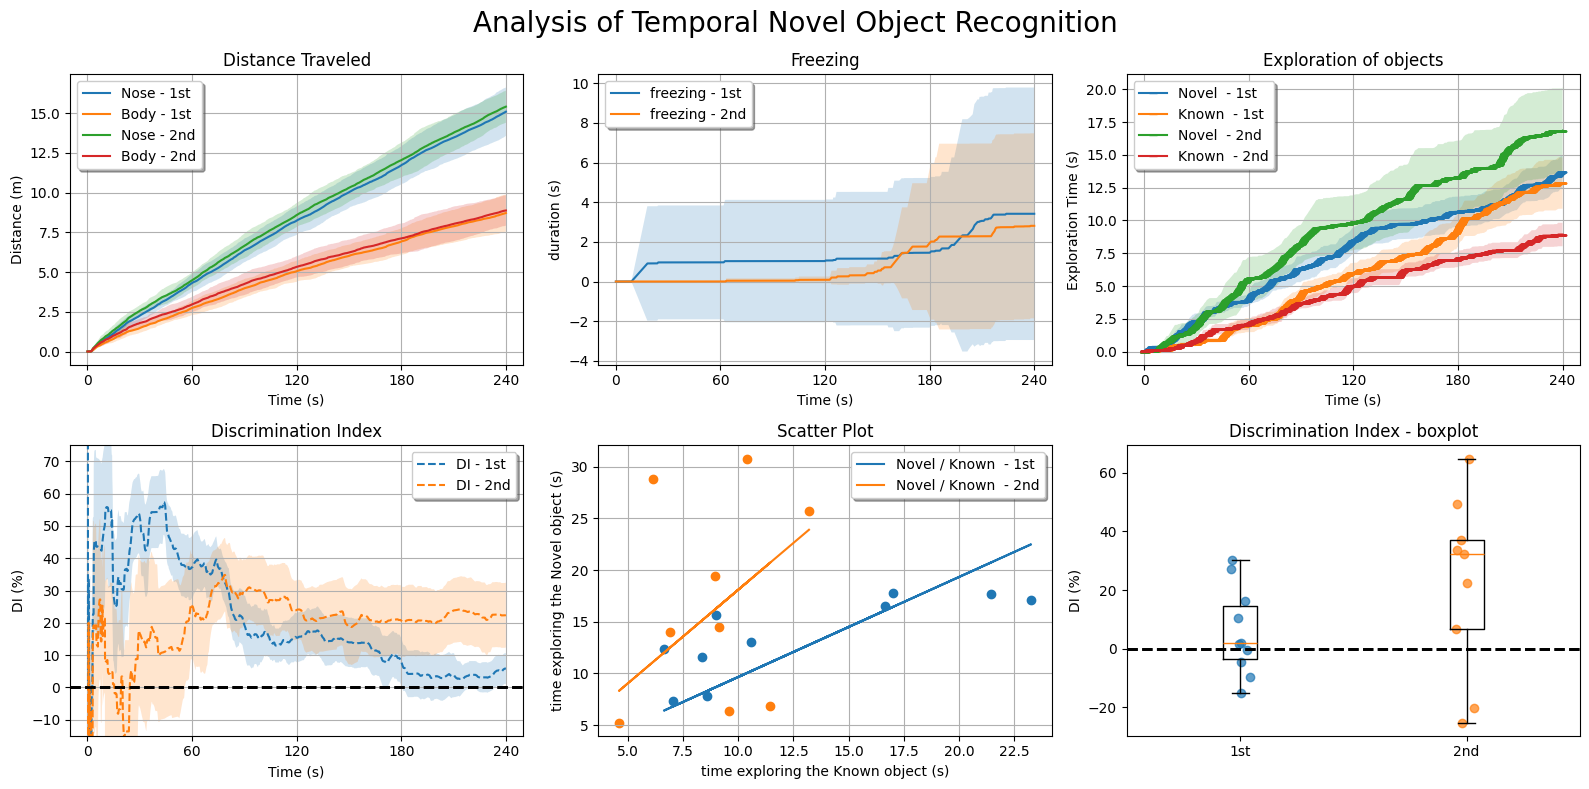

In [105]:
plot_experiment(final_path, groups, time_limit = t_lim, fps = video_fps)